# Bozeman, Montana


Our objective is to find what features of a Air BNB rental property are most correlated with its popularity to help better predict the price of listings. This will benefit Air BNB by improving their marketing strategy, improve developers who are interested in leasing properties on Air BNB, as well as individual leasers who have their homes on the platform. Customers of the app will also benefit from the improved advertising and pricing.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob


### Read Datasets

In [ ]:
# Read Listings Data
file_id_listings = "1EBvXyZvgIcm8y5D7CqSeoWWi7xyYvbPp"
listings = pd.read_csv(f'https://drive.google.com/uc?id={file_id_listings}')

# Read Reviews Data
file_id_reviews = "1jC9Ym1rr12XPXF072ngcM5jGBRKVlvOT"
reviews = pd.read_csv(f'https://drive.google.com/uc?id={file_id_reviews}')

# Read Calendar Data
file_id_calendar = "1lIjT3V3nkdlUnKrq9lBKy7naPJ7juhmc"
calendar = pd.read_csv(f'https://drive.google.com/uc?id={file_id_calendar}')


<ipython-input-3-6f374c6fccb3>:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(f'https://drive.google.com/uc?id={file_id_calendar}')


## Data Cleansing & Preprocessing

#### 1. Listings Dataset

In [ ]:
# Converting 'price' to numeric after removing currency symbols and commas
if 'price' in listings.columns:
    listings['price'] = pd.to_numeric(listings['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Filling missing 'price' values with the median price for continuity
if 'price' in listings.columns:
    median_price = listings['price'].median()
    listings['price'] = listings['price'].fillna(median_price)


In [ ]:

# Filling 'reviews_per_month' with 0 where missing, assuming no reviews if data is missing
if 'reviews_per_month' in listings.columns:
    listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

# Dropping rows with missing 'last_review' data since it may not impact overall analysis
if 'last_review' in listings.columns:
    listings.dropna(subset=['last_review'], inplace=True)

# Handling missing values for other columns
# Fill missing categorical columns with 'Unknown' and numerical columns with median
for column in listings.columns:
    if listings[column].dtype == 'object':
        listings[column] = listings[column].fillna('Not Available')
    else:
        median_value = listings[column].median()
        listings[column] = listings[column].fillna(median_value)

In [ ]:
# Outlier Removal

# Capping 'price' and 'minimum_nights' to remove extreme outliers
if 'price' in listings.columns:
    listings['price'] = listings['price'].clip(upper=800)  # Adjusted upper cap for better cleaning
if 'minimum_nights' in listings.columns:
    listings['minimum_nights'] = listings['minimum_nights'].clip(upper=15)  # Adjusted upper cap for better cleaning


In [ ]:
#Convert the Bathrooms_text column to floats to merge it with the bathroom column for easier analysis

# Function to convert bathrooms_text to a numeric value
def convert_bathrooms_text(bath_text):
    if pd.isna(bath_text):
        return np.nan
    if 'shared' in bath_text.lower():
        return 0.5  # Shared bath assumed to be 0.5
    try:
        return float(bath_text.split()[0])  # Extract the numeric portion
    except ValueError:
        return np.nan

# Apply the function to convert bathrooms_text to numeric
listings['bathrooms_text_numeric'] = listings['bathrooms_text'].apply(convert_bathrooms_text)

# Fill missing bathrooms values with bathrooms_text_numeric
listings['bathrooms'] = listings['bathrooms'].fillna(listings['bathrooms_text_numeric'])

# Drop the bathrooms_text column and the temporary bathrooms_text_numeric column
listings = listings.drop(columns=['bathrooms_text', 'bathrooms_text_numeric'])



In [ ]:
# Additional Data Cleaning Enhancements

# Ensuring consistency in string columns by stripping whitespace and setting proper case for text columns
string_columns = listings.select_dtypes(include='object').columns
listings[string_columns] = listings[string_columns].apply(lambda x: x.str.strip().str.title() if x.dtype == 'object' else x)

# Converting date columns to datetime format for better date handling
date_columns = ['first_review', 'last_review', 'host_since', 'last_scraped']
for column in date_columns:
    if column in listings.columns:
        listings[column] = pd.to_datetime(listings[column], errors='coerce')

# Removing empty columns from the dataset
listings.dropna(axis=1, how='all', inplace=True)



# Removing duplicate rows
listings.drop_duplicates(subset=[col for col in listings.columns if col not in ['longitude', 'latitude']], inplace=True)


### EDA for Listing


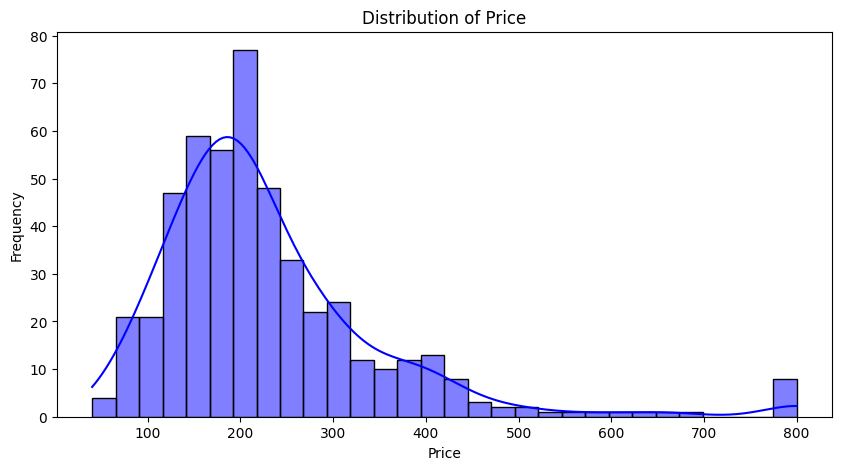

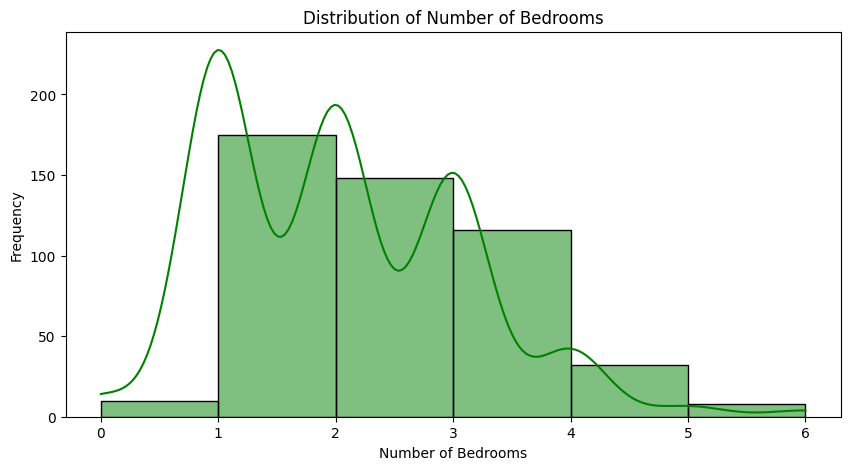

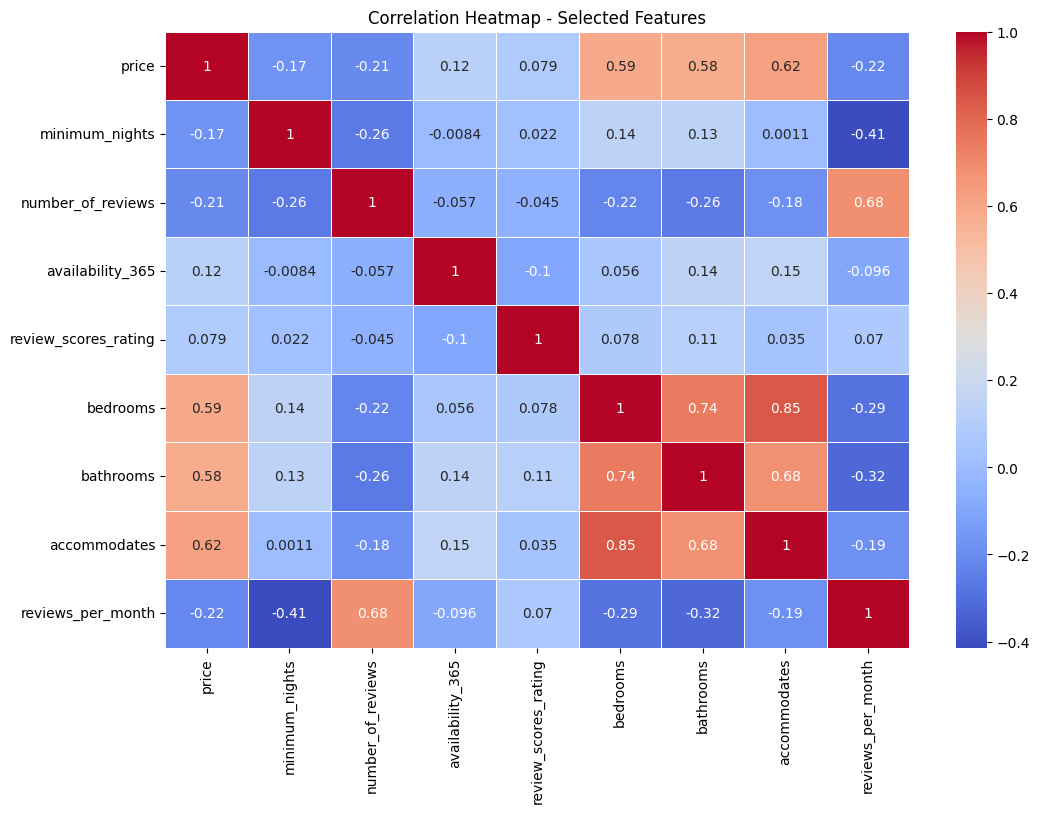

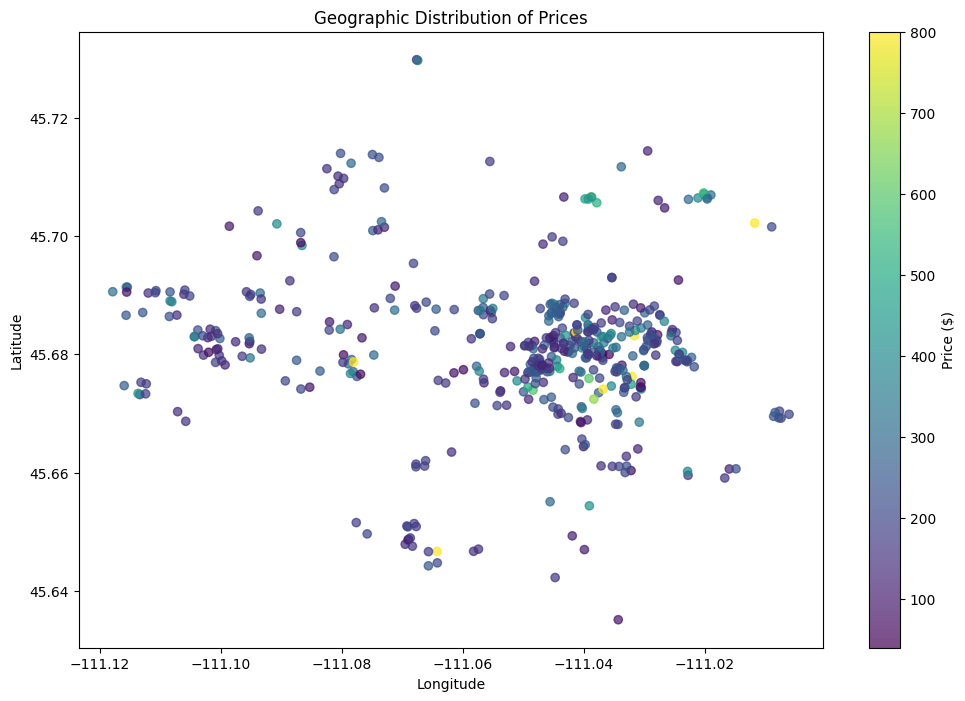

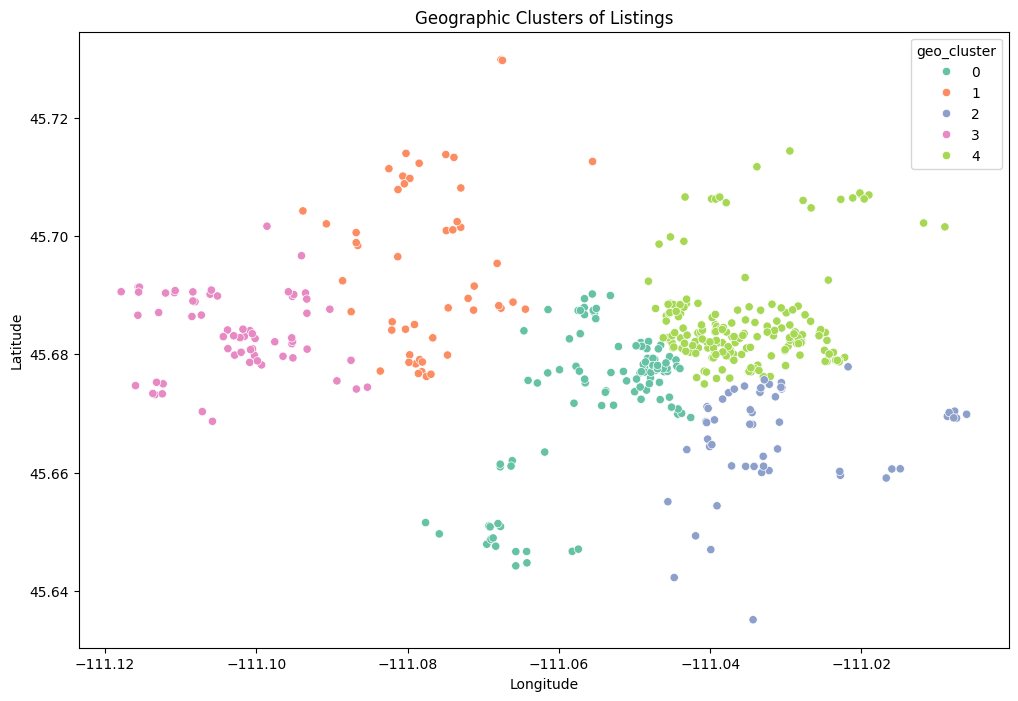

Average Price by Geographic Cluster:
 geo_cluster
0    217.793388
1    218.940000
2    226.018182
3    196.093750
4    251.673367
Name: price, dtype: float64


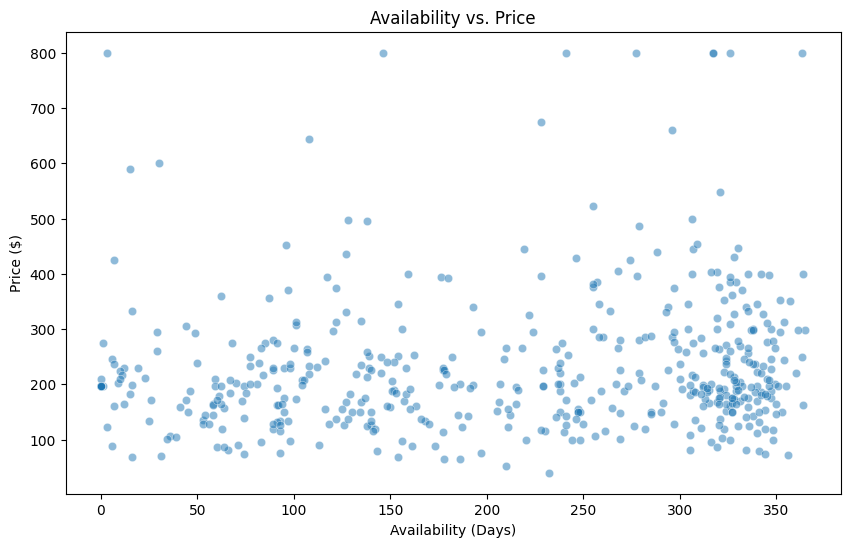

<ipython-input-9-7c2a5582f9af>:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_listings = filtered_listings.groupby('bedrooms', group_keys=False).apply(lambda x: x[x['price'] <= x['price'].quantile(0.90)])
<ipython-input-9-7c2a5582f9af>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bedrooms', y='price', data=filtered_listings, estimator=np.mean, errorbar=None, palette='viridis')


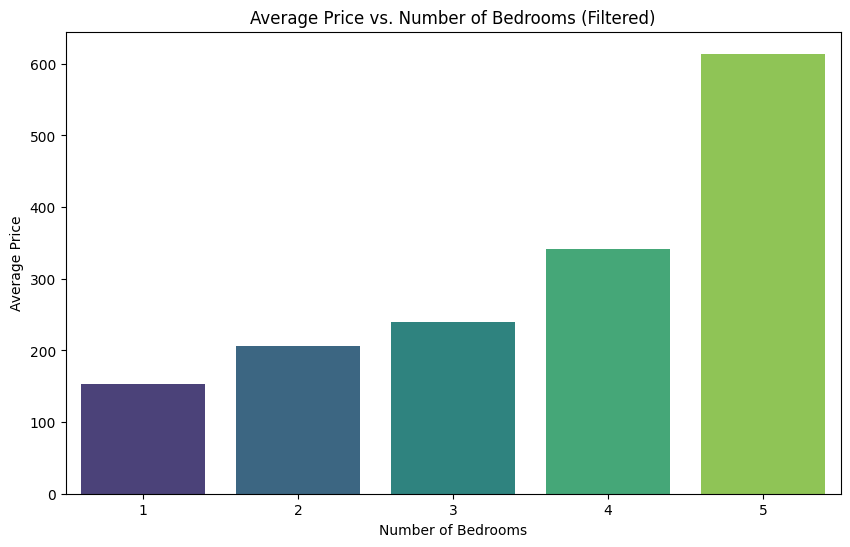

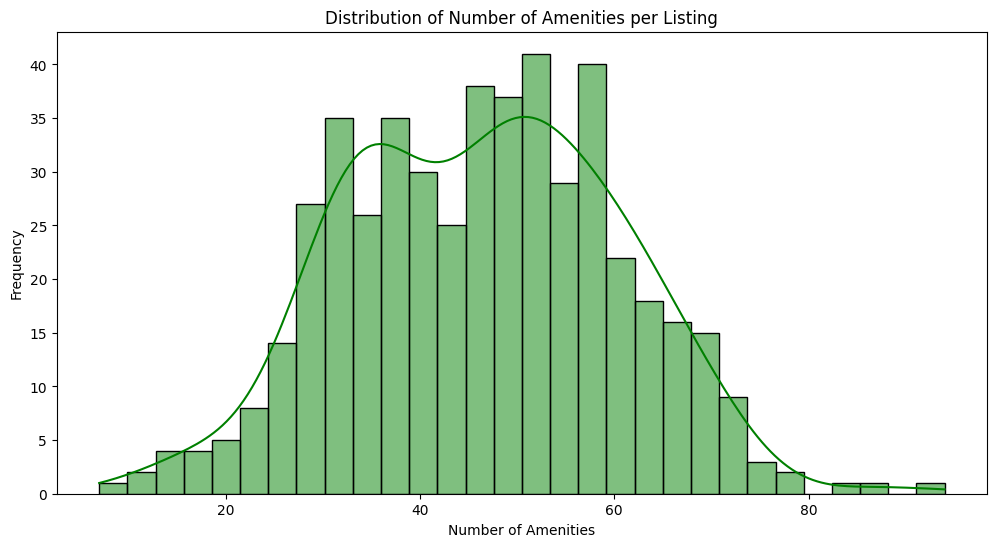

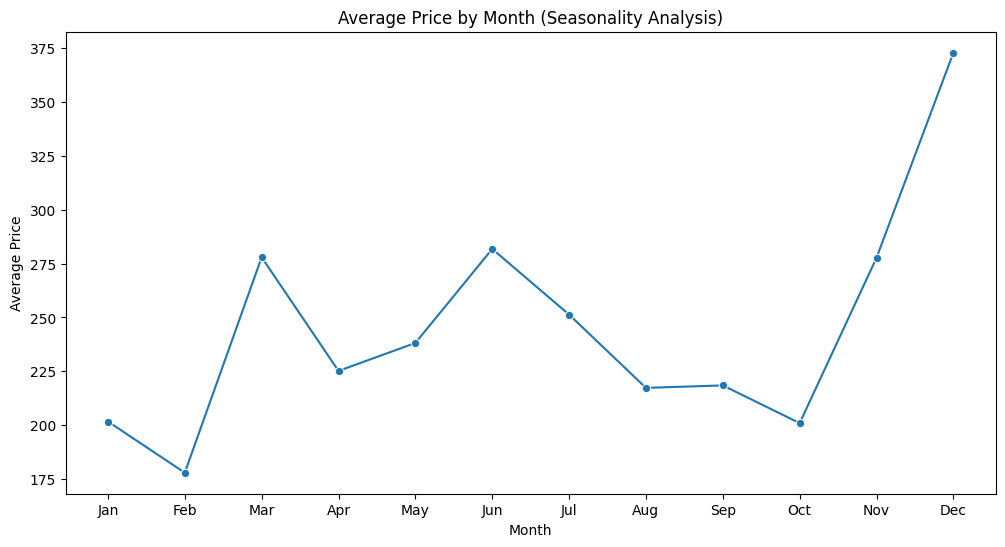

<ipython-input-9-7c2a5582f9af>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=listings, palette='Set2')


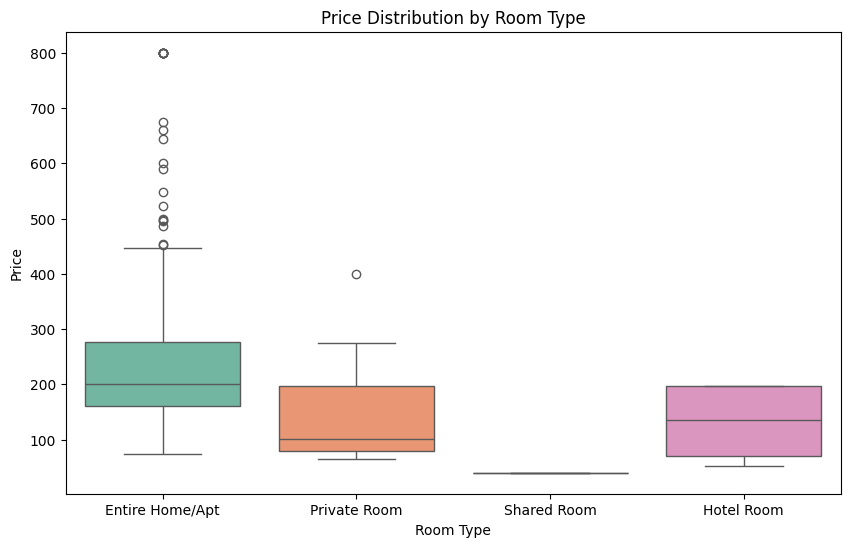

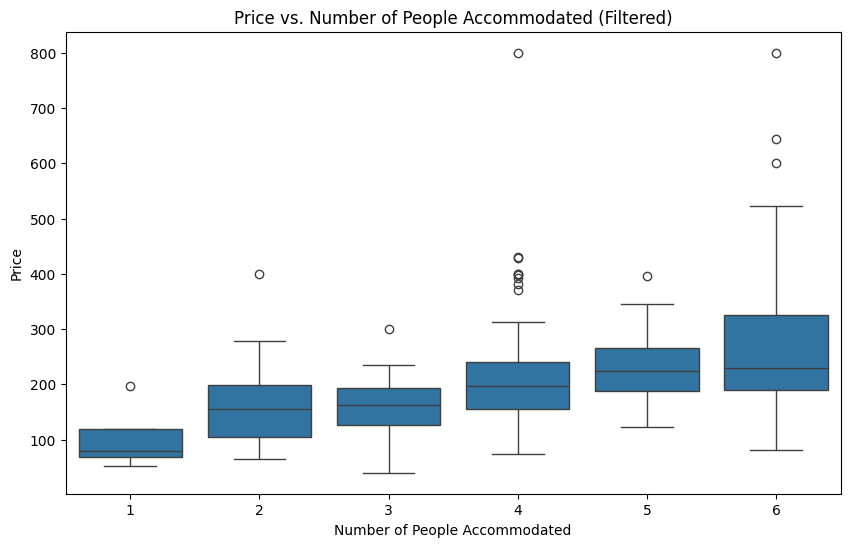

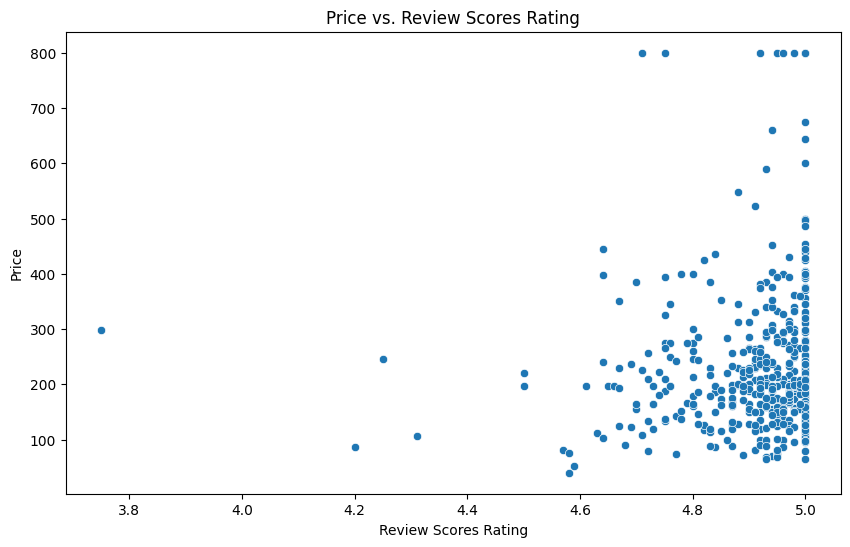

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Distribution of Price
plt.figure(figsize=(10, 5))
sns.histplot(listings['price'], bins=30, kde=True, edgecolor='black', color='blue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Distribution of Number of Bedrooms
plt.figure(figsize=(10, 5))
sns.histplot(listings['bedrooms'], bins=6, kde=True, edgecolor='black', color='green')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Bedrooms')
plt.show()

# Correlation Heatmap with Selected Features
selected_features = ['price', 'minimum_nights', 'number_of_reviews', 'availability_365',
                     'review_scores_rating', 'bedrooms', 'bathrooms', 'accommodates', 'reviews_per_month']
if 'neighbourhood' in listings.columns and listings['neighbourhood'].dtype != 'object': # Check if neighbourhood column exists and is numeric
    selected_features.append('neighbourhood')

corr_matrix = listings[selected_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Selected Features')
plt.show()

# Scatter plot for geographic price distribution
plt.figure(figsize=(12, 8))
plt.scatter(listings['longitude'], listings['latitude'], c=listings['price'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Price ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Prices')
plt.show()

# Perform clustering if latitude and longitude exist
if 'latitude' in listings.columns and 'longitude' in listings.columns:
    geo_features = listings[['latitude', 'longitude']].dropna()

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42).fit(geo_features)
    listings['geo_cluster'] = kmeans.labels_

    # Scatter plot with clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='longitude', y='latitude', hue='geo_cluster', data=listings, palette='Set2')
    plt.title('Geographic Clusters of Listings')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("Error: 'latitude' or 'longitude' column is missing. Clustering cannot be performed.")

# Average price by cluster
geo_price_avg = listings.groupby('geo_cluster')['price'].mean()
print("Average Price by Geographic Cluster:\n", geo_price_avg)

# Scatter plot: Availability vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='availability_365', y='price', data=listings, alpha=0.5)
plt.xlabel('Availability (Days)')
plt.ylabel('Price ($)')
plt.title('Availability vs. Price')
plt.show()

# Line plot: Average Availability by Month
if 'last_review_month' in listings.columns:
    avg_availability_by_month = listings.groupby('last_review_month')['availability_365'].mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=avg_availability_by_month.index, y=avg_availability_by_month.values, marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average Availability (Days)')
    plt.title('Average Availability by Month')
    plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

# Price vs. Number of Bedrooms (Filtered for Common Values and Outliers Removed per Category)
filtered_listings = listings[(listings['bedrooms'] > 0) & (listings['bedrooms'] <= 5)]
filtered_listings = filtered_listings.groupby('bedrooms', group_keys=False).apply(lambda x: x[x['price'] <= x['price'].quantile(0.90)])
plt.figure(figsize=(10, 6))
sns.barplot(x='bedrooms', y='price', data=filtered_listings, estimator=np.mean, errorbar=None, palette='viridis')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price')
plt.title('Average Price vs. Number of Bedrooms (Filtered)')
plt.show()

# Amenities Analysis
if 'amenities' in listings.columns:
    listings['amenities_count'] = listings['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
    plt.figure(figsize=(12, 6))
    sns.histplot(listings['amenities_count'], bins=30, kde=True, color='green', edgecolor='black')
    plt.xlabel('Number of Amenities')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Amenities per Listing')
    plt.show()

# Price Trends by Month (Seasonality Analysis)
listings['last_review_month'] = pd.to_datetime(listings['last_review']).dt.month
plt.figure(figsize=(12, 6))
avg_price_per_month = listings.groupby('last_review_month')['price'].mean()
sns.lineplot(x=avg_price_per_month.index, y=avg_price_per_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Price by Month (Seasonality Analysis)')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Comparison of Price by Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings, palette='Set2')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Price Distribution by Room Type')
plt.show()

# Price vs. Accommodates (Filtered for Common Values)
filtered_listings = listings[listings['accommodates'] <= 6]
plt.figure(figsize=(10, 6))
sns.boxplot(x='accommodates', y='price', data=filtered_listings)
plt.xlabel('Number of People Accommodated')
plt.ylabel('Price')
plt.title('Price vs. Number of People Accommodated (Filtered)')
plt.show()

# Relationship between Price and Review Scores Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='price', data=listings)
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.title('Price vs. Review Scores Rating')
plt.show()


#### Additional Feature Engineering on Listing Dataset

In [ ]:
# Encoding room type
room_type_mapping = {
    'Entire Home/Apt': 1,
    'Private Room': 2,
    'Shared Room': 3,
    'Hotel Room': 4
}

listings['room_type'] = listings['room_type'].map(room_type_mapping)


In [ ]:
# Define the mapping for encoding host response time
response_time_mapping = {
  'Within An Hour': 1,
  'Not Available': 2,
  'Within A Few Hours': 3,
  'Within A Day': 4,
  'A Few Days Or More': 4
}

# Encoding host response time
listings['host_response_time'] = listings['host_response_time'].map(response_time_mapping)


In [ ]:
# Convert date columns to datetime format
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review']) # convert to datetime

# Now you can calculate the difference in days
listings['host_since_days'] = (listings['last_scraped'] - listings['host_since']).dt.days
listings['first_review_days'] = (listings['last_scraped'] - listings['first_review']).dt.days
listings['last_review_days'] = (listings['last_scraped'] - listings['last_review']).dt.days

In [ ]:
# Encode Property Types
listings['property'] = listings['property_type'].astype('category').cat.codes

In [ ]:
listings['amenities'].head()

1    ["Kitchen", "Smoke Alarm", "Wine Glasses", "Cl...
2    ["Kitchen", "Smoke Alarm", "Pack \U2019N Play/...
3    ["Kitchen", "Smoke Alarm", "Babysitter Recomme...
4    ["Kitchen", "Smoke Alarm", "Babysitter Recomme...
5    ["Kitchen", "Smoke Alarm", "Pack \U2019N Play/...
Name: amenities, dtype: object

In [ ]:
def encode_amenities(word, aux):
    """ Creates binary variables based on the presence of a word in a comment  """
    listings[word] = listings['amenities'].apply(lambda x: 1 if (word in x.lower() or aux in x.lower()) else 0)

# Selecting some amenities
encode_amenities('tv', 'television')
encode_amenities('netflix', 'amazon')
encode_amenities('gym', 'gym')
encode_amenities('elevator', 'lift')
encode_amenities('fridge', 'refrigerator')
encode_amenities('heating', 'heating')
encode_amenities('hair_dryer', 'hair dryer')
encode_amenities('air_conditioning', 'air conditioning')
encode_amenities('hot_tub', 'hot tub')
encode_amenities('oven', 'oven')
encode_amenities('bbq', 'barbecue')
encode_amenities('security cameras', 'camera')
encode_amenities('workspace', 'workspace')
encode_amenities('coffee', 'coffee maker')
encode_amenities('backyard', 'backyard')
encode_amenities('outdoor_dining', 'outdoor dining')
encode_amenities('greets', 'host greets')
encode_amenities('pool', 'pool')
encode_amenities('beachfront', 'beach view')
encode_amenities('patio', 'balcony')
encode_amenities('luggage', 'luggage dropoff')
encode_amenities('furniture', 'outdoor furniture')


In [ ]:
# Dropping columns with more than 80% missing values
missing_data_percentage = listings.isnull().sum() / len(listings) * 100
columns_to_drop = missing_data_percentage[missing_data_percentage > 80].index
listings.drop(columns=columns_to_drop, inplace=True)

# Dropping columns with only one unique value
unique_value_columns = [column for column in listings.columns if listings[column].nunique() == 1]
listings.drop(columns=unique_value_columns, inplace=True)


In [ ]:
# Dropping columns that are not useful for analysis
columns_to_drop = [
    'neighbourhood_group', 'neighbourhood', 'source', 'scrape_id',
    'listing_url', 'picture_url', 'host_url', 'license', 'calendar_last_scraped',
    'host_thumbnail_url', 'host_picture_url', 'host_name', 'neighbourhood_cleansed',
    'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_verifications',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'calendar_updated', 'host_location',
    'host_about',
    'host_acceptance_rate',
    'host_listings_count', 'host_total_listings_count',
]

listings = listings.drop(columns=[col for col in columns_to_drop if col in listings.columns])


In [ ]:
listings.to_csv("listings_processed.csv", index=False)

#### 2. Reviews Dataset

In [ ]:
reviews = pd.read_csv(f'https://drive.google.com/uc?id={file_id_reviews}')
reviews.head()


listing_id        id        date  reviewer_id reviewer_name  \
0      505101   2185858  2012-09-03      3372110         Elise   
1      505101   8978609  2013-11-30      9025355        Leslie   
2      505101  11306241  2014-03-29     12954275        Nicole   
3      505101  16537343  2014-07-29      6366027      Kristina   
4      505101  17434984  2014-08-12     15347113       Lindsie   

                                            comments  
0  Amazing, cute, Anthropologie-looking house.  T...  
1  My two young adult children, a dog, and I,thor...  
2  We had a great stay in this cute unique little...  
3        everything about this listing was perfect.   
4  We had a great stay at the cottage. The place ...

In [ ]:
print(reviews.dtypes)

#reviews = reviews.drop('reviewer_name', axis = 1)

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


In [ ]:
# convert 'date' field into date datatype
reviews['date'] = pd.to_datetime(reviews['date'])

# drop 'reviewer's name'
columns_to_drop = ['reviewer_name']
reviews.drop(columns=columns_to_drop, inplace=True)

# Remove rows without 'listing_id' or 'id'
reviews.dropna(subset=['listing_id', 'id', 'comments'], inplace=True)

# Removing duplicate rows
reviews.drop_duplicates(inplace=True)

# Removing empty columns from the dataset
reviews.dropna(axis=1, how='all', inplace=True)


#### Additional Data Preprocessing

In [ ]:
# !pip install nltk

import re
from html import unescape
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text):
    """Cleans and simplifies text by removing unwanted elements."""
    if not isinstance(text, str):  # Handle non-string input gracefully
        return text

    # Remove punctuation and symbols
    text = text.translate(EXCLUDE)
    text = re.sub(r"(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|([^0-9A-Za-z \t])|^rt|http.+?", "", text)

    # Replace '&' and remove stopwords
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in STOPWORDS])

    # Decode HTML entities
    text = unescape(text)

    return text

# Text Processing To Clean Comments for Sentiment Analysis
STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()
EXCLUDE = str.maketrans(',.:;', '    ')  # Translation table for punctuation removal

# Apply clean_text using Pandas' vectorized operations
reviews['comments_cleaned'] = reviews['comments'].astype(str).apply(clean_text)

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Precompute SentimentIntensityAnalyzer with custom lexicon updates
SIA = SentimentIntensityAnalyzer()
CUSTOM_LEXICON = {
    'cancel': -20, 'canceled': -20, 'canceling': -20, 'backpain': -5,
    'bad': -10, 'spiderwebs': -50, 'odor': -30, 'freaked': -30,
    'musty': -50, 'toxic': -5, 'sticky': -15, 'ugly': -15,
    'bedbugs': -60, 'bugs': -20, 'rude': -30, 'aggressive': -30,
    'scary': -15, 'cozy': +10, 'great': +20, 'cosy': +10,
    'smoothly': +30, 'worst': -10, 'convenient': +40, 'worse': -10,
    'exciting': +60, 'notch': +30, 'superhost': +30, 'disappointing': -10,
    'horrible': -30, 'dirty': -15, 'dirt': -15, 'stain': -20,
    'filthy': -30, 'unreliable': -15, 'meh': -5, 'spacious': +10,
    'lovely': +20, 'infested': -15, 'broke': -10, 'broken': -15,
    'awake': -20, 'difficult': -20, '1010': +10
}

SIA.lexicon.update(CUSTOM_LEXICON)

def calc_review_sentiment(sentence):
    """
    Performs sentiment analysis with a pre-trained NLP model and custom rules.
    """
    # Ensure input is a string
    if not isinstance(sentence, str):
        return 0  # Neutral for non-string inputs

    # Get sentiment scores
    sentiment_dict = SIA.polarity_scores(sentence)
    compound = sentiment_dict['compound']

    # Derive overall sentiment
    # if compound >= 0.05:
    #     overall_sentiment = 1  # Positive
    # elif compound <= -0.05:
    #     overall_sentiment = -1  # Negative
    # else:
    #     overall_sentiment = 0  # Neutral

    return compound

# Categorize reviews based on its sentiment - 1 for Positive, -1 for Negative, 0 for Neutral
reviews['sentiment'] = reviews['comments_cleaned'].astype(str).apply(calc_review_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
reviews.to_csv("reviews_processed.csv", index=False)

### Join Reviews with Listings

In [ ]:
reviews.groupby('listing_id')['sentiment'].median().reset_index()['sentiment'].value_counts()

sentiment
0.98180    45
0.98440    19
0.98470    12
0.98580    12
0.98460     9
           ..
0.98995     1
0.98340     1
0.89315     1
0.99645     1
0.88380     1
Name: count, Length: 238, dtype: int64

In [ ]:
# calculate average sentiment per listing
avg_sentiment_per_listing = reviews.groupby('listing_id')['sentiment'].mean().reset_index()
avg_sentiment_per_listing.rename(columns={
    'listing_id': 'id',
    'sentiment': 'avg_sentiment'}, inplace=True)

# join with listings
listings_final = pd.merge(listings, avg_sentiment_per_listing, on='id', how='left')

In [ ]:

# encode categorical features
categorical = ['property', 'property_type']

for i in categorical:
    listings_final[i] = listings_final[i].astype('category')

In [ ]:
# One-hot encoding of boolean features
features = ['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified', 'instant_bookable']

for i in features:
    listings_final[i] = listings_final[i].apply(lambda x: 1 if x == 'T' else 0)


In [ ]:
# drop unused features
unused_features = \
  ['id', 'name', 'neighborhood_overview', 'host_id', 'amenities',
   'availability_60', 'property_type', 'source', 'description',
   'host_since', 'first_review', 'last_review',
   'calculated_host_listings_count_entire_homes',
   'calculated_host_listings_count_private_rooms',
   'calculated_host_listings_count_shared_rooms', 'latitude', 'longitude']

listings_final = listings_final. \
  drop([col for col in unused_features if col in listings_final.columns], axis=1)



In [ ]:
# let us remove '%' from 'host_response_rate' column and convert it into integer

# Replace invalid entries with NaN
listings_final['host_response_rate'] = listings_final['host_response_rate'].replace('Not Available', pd.NA)

# Remove '%' and convert to integer
listings_final['host_response_rate'] = (
    listings_final['host_response_rate']
    .replace('Not Available', None)  # Use None for compatibility with string operations
    .str.replace('%', '', regex=True)  # Remove '%'
    .fillna(0)  # Replace NaNs with 0
    .astype(int)  # Convert to integer
)


In [ ]:
listings_final.to_csv("listings_final.csv", index=False)

#### Wordcloud

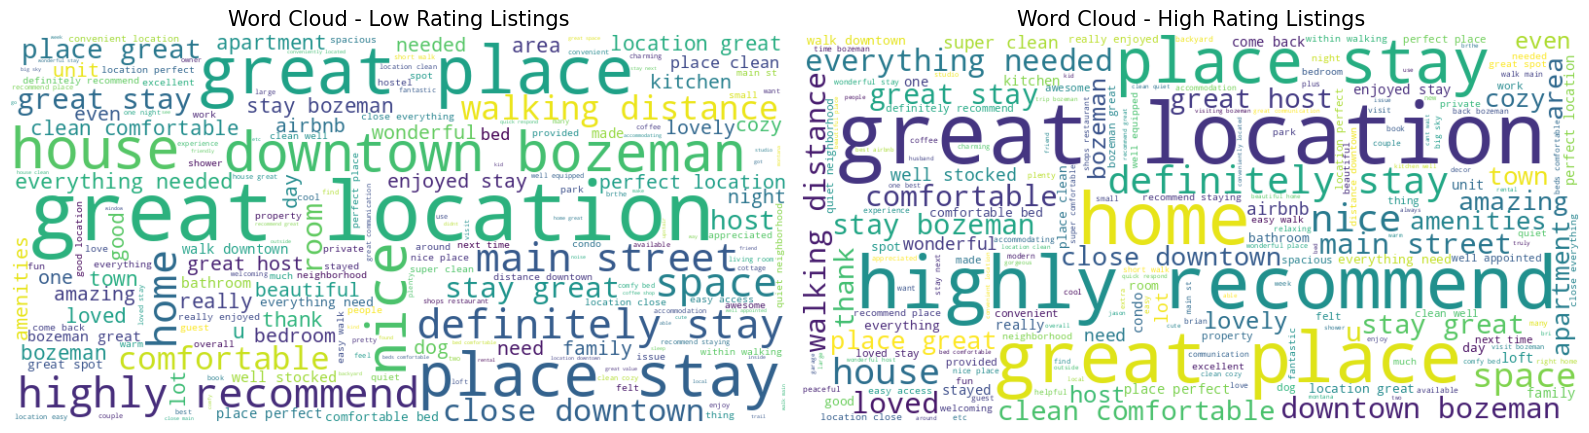

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Merge listings with reviews based on 'id' and 'listing_id'
listings_with_comments = pd.merge(
    listings[['review_scores_rating', 'id']],  # Select 'review_scores_rating' and 'id' from 'listings'
    reviews[['listing_id', 'comments_cleaned']],
    left_on='id',  # Merge on 'id' from 'listings'
    right_on='listing_id',  # Merge on 'listing_id' from 'reviews'
    how='left'
)

# 2. Define review score threshold
rating_threshold = listings_with_comments['review_scores_rating'].median()

# 3. Separate comments for low and high rating listings
low_rating_comments = ' '.join(
    listings_with_comments[listings_with_comments['review_scores_rating'] <= rating_threshold]['comments_cleaned'].astype(str)
)
high_rating_comments = ' '.join(
    listings_with_comments[listings_with_comments['review_scores_rating'] > rating_threshold]['comments_cleaned'].astype(str)
)

# 4. Generate word clouds
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate(low_rating_comments)
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate(high_rating_comments)

# 5. Display word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)  # Create subplot for low rating word cloud
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Low Rating Listings', fontsize=15)

plt.subplot(1, 2, 2)  # Create subplot for high rating word cloud
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - High Rating Listings', fontsize=15)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


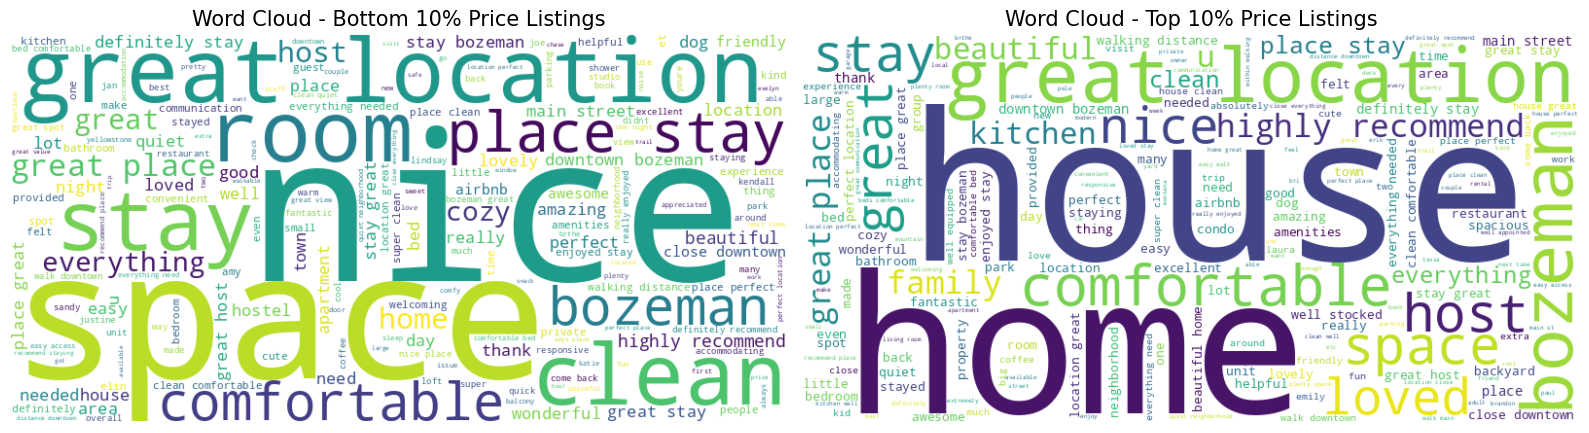

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 2. Define thresholds for bottom 10% and top 10% price listings
low_price_threshold = listings_with_comments['price'].quantile(0.1)
high_price_threshold = listings_with_comments['price'].quantile(0.9)

# 3. Separate comments for bottom 10% and top 10% price listings
low_price_comments = ' '.join(
    listings_with_comments[listings_with_comments['price'] <= low_price_threshold]['comments_cleaned'].astype(str)
)
high_price_comments = ' '.join(
    listings_with_comments[listings_with_comments['price'] >= high_price_threshold]['comments_cleaned'].astype(str)
)

# 4. Generate word clouds
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate(low_price_comments)
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate(high_price_comments)

# 5. Display word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)  # Create subplot for bottom 10% price word cloud
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Bottom 10% Price Listings', fontsize=15)

plt.subplot(1, 2, 2)  # Create subplot for top 10% price word cloud
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Top 10% Price Listings', fontsize=15)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


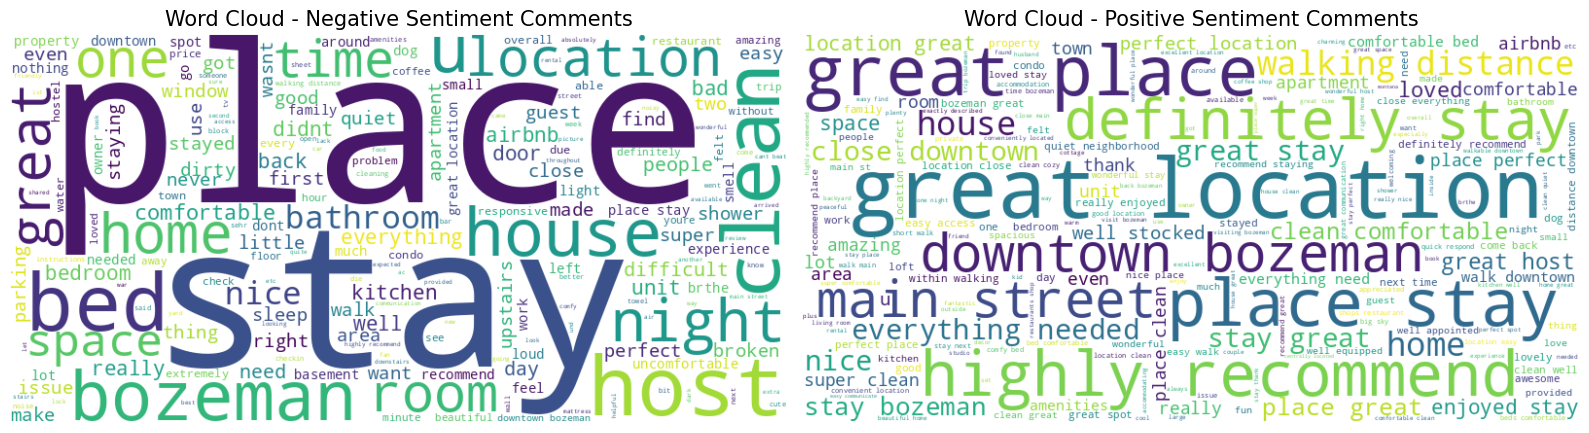

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Merge listings with reviews based on 'id' and 'listing_id'
listings_with_comments = pd.merge(
    listings[['id']],  # Select 'id' from 'listings'
    reviews[['listing_id', 'comments_cleaned', 'sentiment']],
    left_on='id',  # Merge on 'id' from 'listings'
    right_on='listing_id',  # Merge on 'listing_id' from 'reviews'
    how='left'
)

# 2. Separate comments based on numeric sentiment values
negative_comments = ' '.join(
    listings_with_comments[listings_with_comments['sentiment'] < 0]['comments_cleaned'].astype(str)
)
positive_comments = ' '.join(
    listings_with_comments[listings_with_comments['sentiment'] > 0]['comments_cleaned'].astype(str)
)

# 3. Generate word clouds
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

# 4. Display word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)  # Create subplot for negative sentiment word cloud
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Sentiment Comments', fontsize=15)

plt.subplot(1, 2, 2)  # Create subplot for positive sentiment word cloud
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment Comments', fontsize=15)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# Price Prediction Model

## Feature Selection - Multi Collinearity Mitigation

In [ ]:
# Create a new DataFrame excluding the 'price' column
features_df = listings_final.drop(columns=['price'])

#### Identify Highly Correlated Pairs

In [ ]:
# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Identify pairs of features with an absolute correlation above 0.8
high_corr_pairs = (
    correlation_matrix
    .abs()  # Use absolute values of correlations
    .stack()  # Convert to a series
    .reset_index()  # Reset index for easier filtering
)
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Filter pairs where correlation > 0.8 and exclude self-correlation (Correlation = 1)
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Correlation'] > 0.75) & (high_corr_pairs['Feature_1'] != high_corr_pairs['Feature_2'])
].drop_duplicates()

high_corr_pairs



Feature_1               Feature_2  Correlation
356             accommodates                bedrooms     0.845126
357             accommodates                    beds     0.874217
470                 bedrooms            accommodates     0.845126
473                 bedrooms                    beds     0.796515
528                     beds            accommodates     0.874217
530                     beds                bedrooms     0.796515
945    number_of_reviews_ltm  number_of_reviews_l30d     0.791106
955    number_of_reviews_ltm       reviews_per_month     0.898792
1002  number_of_reviews_l30d   number_of_reviews_ltm     0.791106
1013  number_of_reviews_l30d       reviews_per_month     0.780858
1582       reviews_per_month   number_of_reviews_ltm     0.898792
1583       reviews_per_month  number_of_reviews_l30d     0.780858

In [ ]:
# drop the features
redundant_features = ['accommodates', 'beds', 'number_of_reviews_ltm', 'number_of_reviews_l30d']
features_df = features_df.drop(columns=redundant_features)


##### 1. Variance Inflation Factor (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features_df.columns
vif_data["VIF"] = [
    variance_inflation_factor(features_df.values, i)
    for i in range(features_df.shape[1])
]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

Feature          VIF
14            review_scores_rating  7764.911883
18     review_scores_communication  6369.155233
15          review_scores_accuracy  5442.188728
17           review_scores_checkin  4544.284749
19          review_scores_location  3888.189358
16       review_scores_cleanliness  3693.151127
20             review_scores_value  2166.491458
53                   avg_sentiment   181.001282
3             host_has_profile_pic    98.249270
25                 amenities_count    56.012138
35                          fridge    48.210177
36                         heating    43.381868
44                          coffee    38.945148
26               last_review_month    35.369846
5                        room_type    24.348458
37                      hair_dryer    21.309749
1               host_response_rate    21.033313
31                              tv    20.081695
11                 availability_90    17.112867
6                        bathrooms    14.174309
7                         bedrooms    14.000026
30                        property    12.839646
40                            oven    12.111525
27                 host_since_days    10.134248
23               reviews_per_month     8.928198
12                availability_365     7.885342
28               first_review_days     7.856014
4           host_identity_verified     7.415754
13               number_of_reviews     7.335578
0               host_response_time     7.121239
10                 availability_30     6.463610
50                           patio     5.115134
52                       furniture     4.664139
2                host_is_superhost     4.638995
43                       workspace     3.995036
22  calculated_host_listings_count     3.733966
24                     geo_cluster     3.718254
38                air_conditioning     3.479917
8                   minimum_nights     3.469574
45                        backyard     3.405977
41                             bbq     3.055960
9                   maximum_nights     2.761600
46                  outdoor_dining     2.523419
21                instant_bookable     2.269831
51                         luggage     2.217578
29                last_review_days     2.192229
34                        elevator     1.804128
32                         netflix     1.685416
42                security cameras     1.582366
48                            pool     1.393979
47                          greets     1.334408
39                         hot_tub     1.233974
33                             gym     1.199430
49                      beachfront     1.137996

let us iteratively remove the features with VIF > 20

In [ ]:
features_df_temp = features_df.copy()

# Iteratively remove features with VIF > 20
high_vif_features = []
while True:
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features_df_temp.columns
    vif_data["VIF"] = [
        variance_inflation_factor(features_df_temp.values, i)
        for i in range(features_df_temp.shape[1])
    ]

    # Find the feature with the highest VIF
    max_vif = vif_data["VIF"].max()
    if max_vif <= 20:
        break  # Stop if all VIF values are <= 20

    # Remove the feature with the highest VIF
    feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
    features_df_temp = features_df_temp.drop(columns=[feature_to_remove])
    high_vif_features.append(feature_to_remove)

features_df = features_df.drop(columns=[col for col in high_vif_features if col != 'avg_sentiment'])

In [ ]:
features_df.to_csv("features_df_final.csv", index=False)

#### Split Data into Train and Test

In [ ]:
# First, combine the price column with features_df
model_input_df = listings_final[['price']].join(features_df)
model_input_df.head()

price  host_response_time  host_response_rate  host_is_superhost  \
0  125.0                   1                 100                  1   
1  142.0                   1                 100                  0   
2   99.0                   1                 100                  1   
3  180.0                   1                  90                  1   
4  297.0                   1                 100                  1   

   host_identity_verified  room_type  bathrooms  bedrooms  minimum_nights  \
0                       1          1        2.0         2              15   
1                       1          1        1.0         1               1   
2                       0          1        1.0         1              15   
3                       1          1        1.0         1               2   
4                       1          1        2.0         3               2   

   maximum_nights  ...  workspace  backyard  outdoor_dining  greets  pool  \
0            1125  ...          1         0               0       0     0   
1              30  ...          0         1               0       0     0   
2              60  ...          1         0               0       0     0   
3             730  ...          1         1               1       0     0   
4            1125  ...          1         1               0       0     0   

   beachfront  patio  luggage  furniture  avg_sentiment  
0           0      1        1          1       0.993200  
1           0      0        1          1       0.864673  
2           0      1        1          1       0.885078  
3           0      1        0          1       0.914697  
4           0      1        1          1       0.904834  

[5 rows x 42 columns]

In [ ]:
model_input_df.to_csv("model_input_df_final.csv", index=False)

In [ ]:
# Separate features and target
X = model_input_df.drop(columns=['price'])
y = model_input_df['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model 0 - Simple Correlation With Target Variable

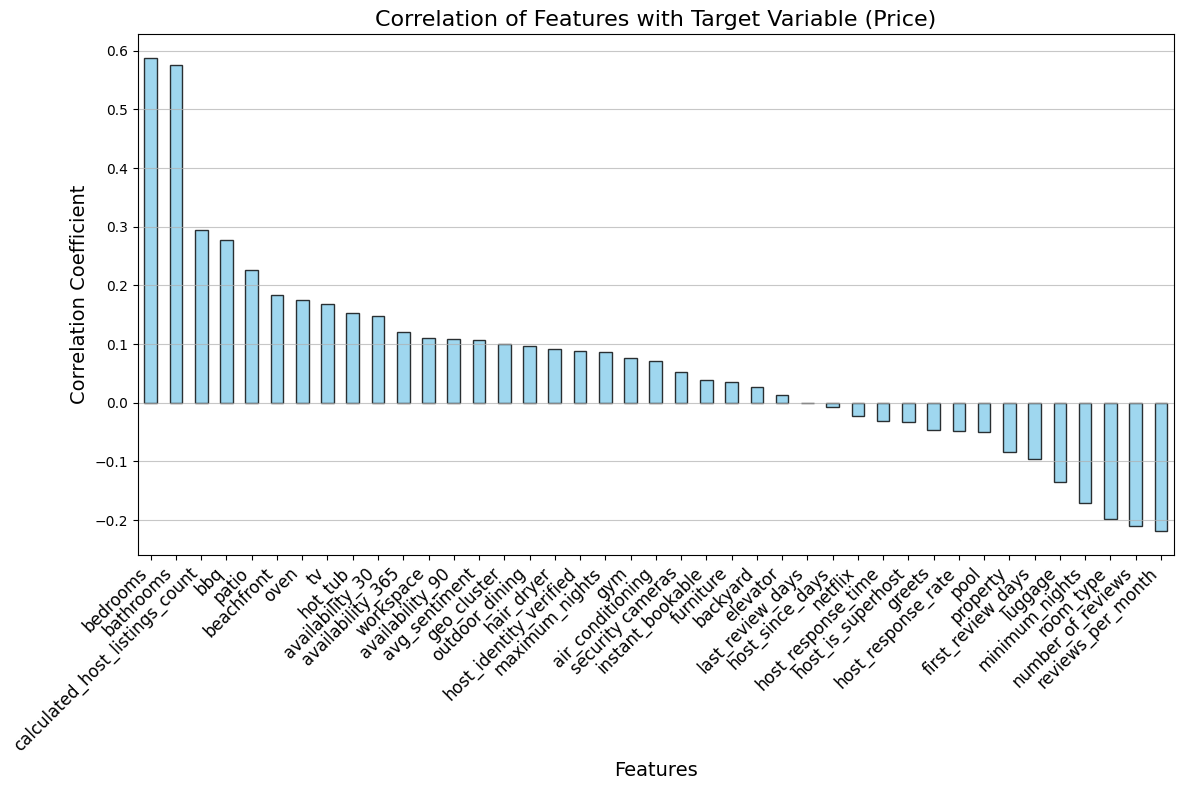

In [ ]:
# Calculate correlation of all features with the target variable (price)
correlation = model_input_df.corr()['price'].drop('price')

# Sort correlations in descending order
correlation_sorted = correlation.sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
correlation_sorted.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Correlation of Features with Target Variable (Price)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()


### Model 1 - Standard OLS Model

In [ ]:
import statsmodels.api as sm

# Add a constant term for the intercept in statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Iteratively remove features with p-values above 0.1
p_value_threshold = 0.1
X_train_iter = X_train_sm.copy()
removed_features = []
while True:
    # Fit OLS model
    ols_model_iter = sm.OLS(y_train, X_train_iter)
    ols_results_iter = ols_model_iter.fit()

    # Get p-values
    p_values = ols_results_iter.pvalues

    # Check for the largest p-value above the threshold
    max_p_value = p_values.max()
    if max_p_value > p_value_threshold:
        # Identify the feature with the largest p-value
        feature_to_remove = p_values.idxmax()

        # Align indices before dropping columns
        X_train_iter = X_train_iter.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)


        X_train_iter = X_train_iter.drop(columns=[feature_to_remove])
        removed_features.append(feature_to_remove)
    else:
        # Stop when all p-values are below the threshold
        break

# Fit the final model after removing insignificant features
final_ols_model = sm.OLS(y_train, X_train_iter)
final_ols_results = final_ols_model.fit()

# Display the final model summary and the removed features
final_model_summary = final_ols_results.summary()
removed_features_df = pd.DataFrame({"Removed Features": removed_features})


In [ ]:
print(final_model_summary)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              251.9
Date:                Mon, 09 Dec 2024   Prob (F-statistic):                   1.71e-181
Time:                        02:26:15   Log-Likelihood:                         -2280.5
No. Observations:                 391   AIC:                                      4589.
Df Residuals:                     377   BIC:                                      4645.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

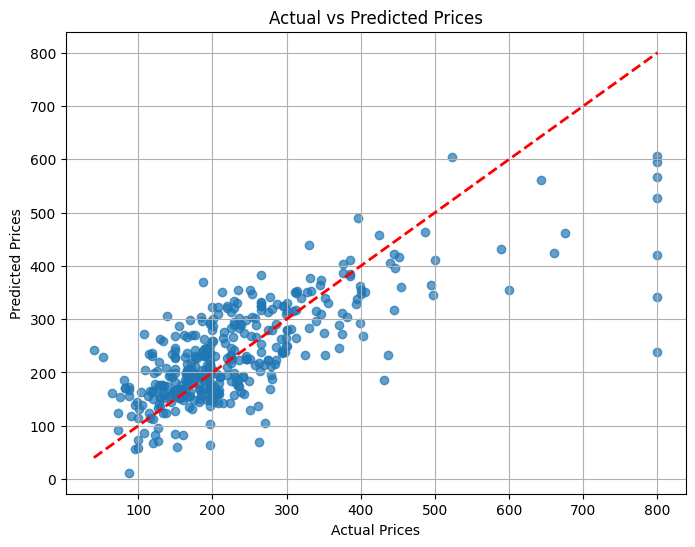

In [ ]:
import matplotlib.pyplot as plt

# Make predictions using the final model on the training data
y_train_pred = final_ols_results.predict(X_train_iter)

# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True)
plt.show()


In [ ]:
# Performance on the test dataset
from sklearn.metrics import r2_score

# Predict on the test dataset using the final OLS model
X_test_sm = X_test_sm.drop(columns=[col for col in removed_features if col in X_test_sm.columns])
y_test_pred = final_ols_results.predict(X_test_sm)

# Calculate R-squared on the test dataset (retry)
test_r_squared = r2_score(y_test, y_test_pred)

print(f"R-squared on the test dataset: {round(test_r_squared, 3)}")


R-squared on the test dataset: 0.55


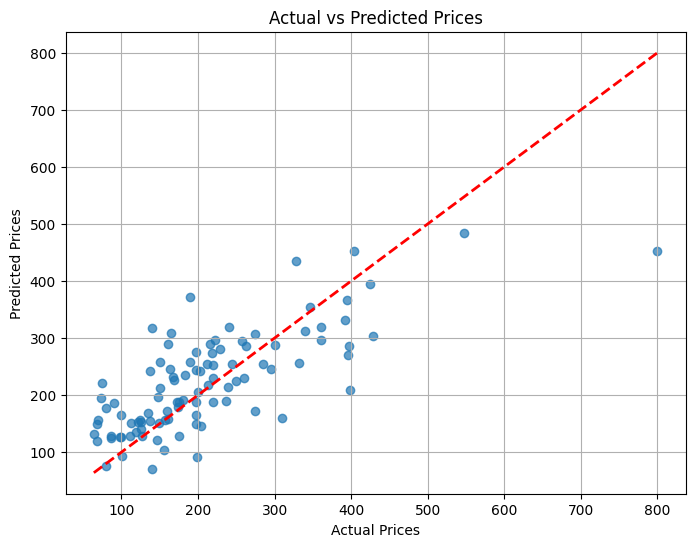

In [ ]:
import matplotlib.pyplot as plt

# Make predictions using the final model on the test data

# Plot actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.grid(True)
plt.show()


### Model 2 - Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Define hyperparameter space with probability distributions
space = {
    'n_estimators': hp.quniform("n_estimators", 150, 300, 1),
    'max_depth': hp.quniform('max_depth', 100, 1000, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 4, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 3, 1),
    'max_features': hp.uniform('max_features', 0.3, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 0.6),
    'warm_start': hp.choice('warm_start', [True, False]),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 2.0)
}

def objective(space):
    # Set up Random Forest Algorithm
    rf = RandomForestRegressor(n_estimators=int(space['n_estimators']),
                                    max_depth=int(space['max_depth']), bootstrap=True,
                                    min_samples_split=int(space['min_samples_split']),
                                    min_samples_leaf=int(space['min_samples_leaf']),
                                    max_features=space['max_features'], n_jobs=-1,
                                    warm_start=True if space['warm_start'] else False,
                                                ccp_alpha=space['ccp_alpha'])

    # Fit Algorithm to training data
    rf.fit(X_train, y_train)
    pred = rf.predict(X_train)
    rmse = mean_squared_error(y_train, pred, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}

# Start Hyperparameter Optimization with TPE Algorithm
trials = Trials()
hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=300, trials=trials)

  0%|          | 1/300 [00:00<02:30,  1.98trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  1%|          | 2/300 [00:00<02:15,  2.19trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  1%|          | 3/300 [00:01<02:31,  1.96trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  1%|▏         | 4/300 [00:02<03:12,  1.54trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  2%|▏         | 5/300 [00:03<03:37,  1.35trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  2%|▏         | 6/300 [00:03<03:27,  1.42trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  2%|▏         | 7/300 [00:04<03:32,  1.38trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  3%|▎         | 8/300 [00:05<03:42,  1.31trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  3%|▎         | 9/300 [00:06<03:22,  1.44trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  3%|▎         | 10/300 [00:06<02:55,  1.65trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  4%|▎         | 11/300 [00:07<03:07,  1.54trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  4%|▍         | 12/300 [00:08<03:29,  1.37trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  4%|▍         | 13/300 [00:09<03:48,  1.26trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  5%|▍         | 14/300 [00:10<05:08,  1.08s/trial, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  5%|▌         | 15/300 [00:12<05:52,  1.24s/trial, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  5%|▌         | 16/300 [00:13<05:19,  1.13s/trial, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  6%|▌         | 17/300 [00:13<04:29,  1.05trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  6%|▌         | 18/300 [00:14<04:13,  1.11trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  6%|▋         | 19/300 [00:15<04:12,  1.11trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  7%|▋         | 20/300 [00:16<04:16,  1.09trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  7%|▋         | 21/300 [00:17<04:09,  1.12trial/s, best loss: 31.46600856549634]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  7%|▋         | 22/300 [00:17<03:48,  1.22trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  8%|▊         | 23/300 [00:18<03:40,  1.25trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  8%|▊         | 24/300 [00:19<03:37,  1.27trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  8%|▊         | 25/300 [00:20<03:37,  1.26trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  9%|▊         | 26/300 [00:20<03:23,  1.35trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  9%|▉         | 27/300 [00:21<03:20,  1.36trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  9%|▉         | 28/300 [00:22<03:12,  1.41trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 10%|▉         | 29/300 [00:23<03:41,  1.23trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 10%|█         | 30/300 [00:24<03:53,  1.16trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 10%|█         | 31/300 [00:25<04:55,  1.10s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 11%|█         | 32/300 [00:26<04:18,  1.04trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 11%|█         | 33/300 [00:27<03:51,  1.16trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 11%|█▏        | 34/300 [00:27<03:33,  1.25trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 12%|█▏        | 35/300 [00:28<03:15,  1.35trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 12%|█▏        | 36/300 [00:28<02:55,  1.51trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 12%|█▏        | 37/300 [00:29<02:32,  1.72trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 13%|█▎        | 38/300 [00:30<03:05,  1.41trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 13%|█▎        | 39/300 [00:30<02:59,  1.45trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 13%|█▎        | 40/300 [00:32<03:26,  1.26trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 14%|█▎        | 41/300 [00:32<03:21,  1.28trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 14%|█▍        | 42/300 [00:33<03:07,  1.37trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 14%|█▍        | 43/300 [00:34<03:01,  1.42trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 15%|█▍        | 44/300 [00:34<02:52,  1.49trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 15%|█▌        | 45/300 [00:35<02:36,  1.63trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 15%|█▌        | 46/300 [00:35<02:46,  1.52trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 16%|█▌        | 47/300 [00:36<03:11,  1.32trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 16%|█▌        | 48/300 [00:38<03:41,  1.14trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 16%|█▋        | 49/300 [00:39<04:00,  1.04trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 17%|█▋        | 50/300 [00:40<04:21,  1.05s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 17%|█▋        | 51/300 [00:41<04:07,  1.01trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 17%|█▋        | 52/300 [00:41<03:42,  1.11trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 18%|█▊        | 53/300 [00:42<03:21,  1.22trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 18%|█▊        | 54/300 [00:43<03:18,  1.24trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 18%|█▊        | 55/300 [00:44<03:07,  1.31trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 19%|█▊        | 56/300 [00:44<03:19,  1.22trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 19%|█▉        | 57/300 [00:45<03:06,  1.31trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 19%|█▉        | 58/300 [00:46<03:06,  1.30trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|█▉        | 59/300 [00:47<03:16,  1.22trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 60/300 [00:47<02:56,  1.36trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 61/300 [00:48<02:39,  1.50trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 21%|██        | 62/300 [00:49<02:43,  1.46trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 21%|██        | 63/300 [00:50<03:01,  1.31trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 21%|██▏       | 64/300 [00:51<03:12,  1.22trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 22%|██▏       | 65/300 [00:52<03:43,  1.05trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 22%|██▏       | 66/300 [00:53<04:23,  1.13s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 22%|██▏       | 67/300 [00:54<04:01,  1.04s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 23%|██▎       | 68/300 [00:55<03:40,  1.05trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 23%|██▎       | 69/300 [00:56<03:18,  1.16trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 23%|██▎       | 70/300 [00:56<03:03,  1.25trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 24%|██▎       | 71/300 [00:57<02:59,  1.28trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 24%|██▍       | 72/300 [00:58<03:08,  1.21trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 24%|██▍       | 73/300 [00:59<03:20,  1.13trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 25%|██▍       | 74/300 [01:00<03:08,  1.20trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 25%|██▌       | 75/300 [01:00<02:59,  1.25trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 25%|██▌       | 76/300 [01:01<02:54,  1.28trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 26%|██▌       | 77/300 [01:02<02:53,  1.28trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 26%|██▌       | 78/300 [01:03<02:49,  1.31trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 26%|██▋       | 79/300 [01:03<02:41,  1.37trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 27%|██▋       | 80/300 [01:04<02:50,  1.29trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 27%|██▋       | 81/300 [01:05<03:17,  1.11trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 27%|██▋       | 82/300 [01:06<03:30,  1.04trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 28%|██▊       | 83/300 [01:07<03:20,  1.08trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 28%|██▊       | 84/300 [01:08<02:53,  1.25trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 28%|██▊       | 85/300 [01:08<02:39,  1.35trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 29%|██▊       | 86/300 [01:09<02:29,  1.43trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 29%|██▉       | 87/300 [01:10<02:27,  1.44trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 29%|██▉       | 88/300 [01:10<02:19,  1.51trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|██▉       | 89/300 [01:11<02:21,  1.49trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 90/300 [01:12<02:36,  1.35trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 91/300 [01:12<02:25,  1.43trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 31%|███       | 92/300 [01:13<02:16,  1.52trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 31%|███       | 93/300 [01:14<02:12,  1.56trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 31%|███▏      | 94/300 [01:14<02:16,  1.51trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 32%|███▏      | 95/300 [01:15<02:26,  1.40trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 32%|███▏      | 96/300 [01:16<02:40,  1.27trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 32%|███▏      | 97/300 [01:17<02:43,  1.24trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 33%|███▎      | 98/300 [01:18<03:20,  1.01trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 33%|███▎      | 99/300 [01:20<03:34,  1.07s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 33%|███▎      | 100/300 [01:20<03:18,  1.01trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 34%|███▎      | 101/300 [01:21<03:19,  1.00s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 34%|███▍      | 102/300 [01:23<03:22,  1.02s/trial, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 34%|███▍      | 103/300 [01:23<02:58,  1.10trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 35%|███▍      | 104/300 [01:24<02:53,  1.13trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 35%|███▌      | 105/300 [01:25<02:45,  1.18trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 35%|███▌      | 106/300 [01:26<02:45,  1.18trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 36%|███▌      | 107/300 [01:26<02:27,  1.30trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 36%|███▌      | 108/300 [01:27<02:25,  1.32trial/s, best loss: 30.53885439448552]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 36%|███▋      | 109/300 [01:28<02:42,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 37%|███▋      | 110/300 [01:29<02:46,  1.14trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 37%|███▋      | 111/300 [01:30<02:44,  1.15trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 37%|███▋      | 112/300 [01:31<03:19,  1.06s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 38%|███▊      | 113/300 [01:33<04:03,  1.30s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 38%|███▊      | 114/300 [01:34<03:55,  1.26s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 38%|███▊      | 115/300 [01:35<03:36,  1.17s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 39%|███▊      | 116/300 [01:36<03:21,  1.10s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 39%|███▉      | 117/300 [01:37<03:13,  1.06s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 39%|███▉      | 118/300 [01:38<03:08,  1.03s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|███▉      | 119/300 [01:39<02:55,  1.03trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 120/300 [01:40<02:43,  1.10trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 121/300 [01:41<02:56,  1.01trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 41%|████      | 122/300 [01:42<02:46,  1.07trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 41%|████      | 123/300 [01:43<02:42,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 41%|████▏     | 124/300 [01:43<02:28,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 42%|████▏     | 125/300 [01:44<02:33,  1.14trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 42%|████▏     | 126/300 [01:46<03:25,  1.18s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 42%|████▏     | 127/300 [01:47<03:20,  1.16s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 43%|████▎     | 128/300 [01:48<03:10,  1.11s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 43%|████▎     | 129/300 [01:49<02:59,  1.05s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 43%|████▎     | 130/300 [01:50<02:38,  1.07trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 44%|████▎     | 131/300 [01:50<02:21,  1.19trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 44%|████▍     | 132/300 [01:51<02:23,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 44%|████▍     | 133/300 [01:52<02:33,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 45%|████▍     | 134/300 [01:53<02:14,  1.23trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 45%|████▌     | 135/300 [01:54<02:02,  1.34trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 45%|████▌     | 136/300 [01:54<02:09,  1.27trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 46%|████▌     | 137/300 [01:55<02:15,  1.20trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 46%|████▌     | 138/300 [01:56<02:22,  1.14trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 46%|████▋     | 139/300 [01:57<02:09,  1.24trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 47%|████▋     | 140/300 [01:58<01:59,  1.33trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 47%|████▋     | 141/300 [01:59<02:34,  1.03trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 47%|████▋     | 142/300 [02:00<02:42,  1.03s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 48%|████▊     | 143/300 [02:02<02:57,  1.13s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 48%|████▊     | 144/300 [02:02<02:34,  1.01trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 48%|████▊     | 145/300 [02:03<02:35,  1.00s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 49%|████▊     | 146/300 [02:04<02:28,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 49%|████▉     | 147/300 [02:05<02:26,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 49%|████▉     | 148/300 [02:06<02:26,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|████▉     | 149/300 [02:07<02:22,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 150/300 [02:08<02:22,  1.05trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 151/300 [02:09<02:14,  1.11trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 51%|█████     | 152/300 [02:10<02:19,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 51%|█████     | 153/300 [02:11<02:19,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 51%|█████▏    | 154/300 [02:12<02:24,  1.01trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 52%|█████▏    | 155/300 [02:13<02:42,  1.12s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 52%|█████▏    | 156/300 [02:15<03:16,  1.36s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 52%|█████▏    | 157/300 [02:16<02:55,  1.23s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 53%|█████▎    | 158/300 [02:17<02:40,  1.13s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 53%|█████▎    | 159/300 [02:18<02:28,  1.05s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 53%|█████▎    | 160/300 [02:19<02:26,  1.05s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 54%|█████▎    | 161/300 [02:20<02:30,  1.08s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 54%|█████▍    | 162/300 [02:21<02:22,  1.03s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 54%|█████▍    | 163/300 [02:22<02:28,  1.08s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 55%|█████▍    | 164/300 [02:23<02:23,  1.06s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 55%|█████▌    | 165/300 [02:24<02:04,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 55%|█████▌    | 166/300 [02:24<01:50,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 56%|█████▌    | 167/300 [02:25<01:52,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 56%|█████▌    | 168/300 [02:26<02:03,  1.07trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 56%|█████▋    | 169/300 [02:28<02:18,  1.06s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 57%|█████▋    | 170/300 [02:29<02:28,  1.14s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 57%|█████▋    | 171/300 [02:30<02:14,  1.04s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 57%|█████▋    | 172/300 [02:31<01:59,  1.07trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 58%|█████▊    | 173/300 [02:31<01:47,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 58%|█████▊    | 174/300 [02:32<01:42,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 58%|█████▊    | 175/300 [02:33<01:39,  1.26trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 59%|█████▊    | 176/300 [02:33<01:36,  1.29trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 59%|█████▉    | 177/300 [02:34<01:31,  1.35trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 59%|█████▉    | 178/300 [02:35<01:25,  1.42trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|█████▉    | 179/300 [02:36<01:30,  1.34trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 180/300 [02:36<01:33,  1.28trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 181/300 [02:37<01:26,  1.37trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 61%|██████    | 182/300 [02:38<01:22,  1.43trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 61%|██████    | 183/300 [02:38<01:22,  1.42trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 61%|██████▏   | 184/300 [02:39<01:19,  1.46trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 62%|██████▏   | 185/300 [02:40<01:37,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 62%|██████▏   | 186/300 [02:42<01:52,  1.01trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 62%|██████▏   | 187/300 [02:43<02:10,  1.15s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 63%|██████▎   | 188/300 [02:44<01:54,  1.02s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 63%|██████▎   | 189/300 [02:44<01:36,  1.15trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 63%|██████▎   | 190/300 [02:45<01:27,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 64%|██████▎   | 191/300 [02:46<01:23,  1.31trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 64%|██████▍   | 192/300 [02:46<01:14,  1.45trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 64%|██████▍   | 193/300 [02:47<01:15,  1.41trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 65%|██████▍   | 194/300 [02:48<01:15,  1.40trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 65%|██████▌   | 195/300 [02:48<01:09,  1.51trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 65%|██████▌   | 196/300 [02:49<01:14,  1.39trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 66%|██████▌   | 197/300 [02:50<01:14,  1.38trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 66%|██████▌   | 198/300 [02:50<01:12,  1.42trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 66%|██████▋   | 199/300 [02:51<01:06,  1.53trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 67%|██████▋   | 200/300 [02:52<01:05,  1.52trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 67%|██████▋   | 201/300 [02:52<01:08,  1.45trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 67%|██████▋   | 202/300 [02:54<01:20,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 68%|██████▊   | 203/300 [02:55<01:36,  1.00trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 68%|██████▊   | 204/300 [02:56<01:44,  1.09s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 68%|██████▊   | 205/300 [02:57<01:39,  1.05s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 69%|██████▊   | 206/300 [02:58<01:31,  1.03trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 69%|██████▉   | 207/300 [02:59<01:18,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 69%|██████▉   | 208/300 [02:59<01:19,  1.16trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|██████▉   | 209/300 [03:00<01:15,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|███████   | 210/300 [03:01<01:13,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|███████   | 211/300 [03:02<01:15,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 71%|███████   | 212/300 [03:02<01:05,  1.33trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 71%|███████   | 213/300 [03:03<01:04,  1.35trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 71%|███████▏  | 214/300 [03:04<01:08,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 72%|███████▏  | 215/300 [03:05<01:03,  1.34trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 72%|███████▏  | 216/300 [03:05<01:02,  1.35trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 72%|███████▏  | 217/300 [03:06<01:03,  1.31trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 73%|███████▎  | 218/300 [03:07<01:05,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 73%|███████▎  | 219/300 [03:08<01:11,  1.13trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 73%|███████▎  | 220/300 [03:09<01:19,  1.01trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 74%|███████▎  | 221/300 [03:10<01:16,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 74%|███████▍  | 222/300 [03:11<01:06,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 74%|███████▍  | 223/300 [03:12<01:03,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 75%|███████▍  | 224/300 [03:12<01:00,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 75%|███████▌  | 225/300 [03:13<00:59,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 75%|███████▌  | 226/300 [03:14<00:54,  1.36trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 76%|███████▌  | 227/300 [03:15<00:59,  1.23trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 76%|███████▌  | 228/300 [03:16<00:59,  1.20trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 76%|███████▋  | 229/300 [03:17<00:58,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 77%|███████▋  | 230/300 [03:17<00:54,  1.28trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 77%|███████▋  | 231/300 [03:18<00:56,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 77%|███████▋  | 232/300 [03:19<01:03,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 78%|███████▊  | 233/300 [03:20<00:57,  1.16trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 78%|███████▊  | 234/300 [03:21<00:59,  1.10trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 78%|███████▊  | 235/300 [03:22<01:00,  1.08trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 79%|███████▊  | 236/300 [03:23<00:59,  1.07trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 79%|███████▉  | 237/300 [03:24<00:59,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 79%|███████▉  | 238/300 [03:25<00:58,  1.06trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|███████▉  | 239/300 [03:25<00:51,  1.19trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|████████  | 240/300 [03:27<00:56,  1.05trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|████████  | 241/300 [03:27<00:47,  1.24trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 81%|████████  | 242/300 [03:28<00:45,  1.28trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 81%|████████  | 243/300 [03:29<00:46,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 81%|████████▏ | 244/300 [03:30<00:51,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 82%|████████▏ | 245/300 [03:31<00:47,  1.16trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 82%|████████▏ | 246/300 [03:32<00:46,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 82%|████████▏ | 247/300 [03:32<00:41,  1.29trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 83%|████████▎ | 248/300 [03:33<00:40,  1.30trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 83%|████████▎ | 249/300 [03:34<00:37,  1.36trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 83%|████████▎ | 250/300 [03:35<00:51,  1.02s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 84%|████████▎ | 251/300 [03:37<00:55,  1.14s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 84%|████████▍ | 252/300 [03:38<00:53,  1.12s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 84%|████████▍ | 253/300 [03:38<00:47,  1.00s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 85%|████████▍ | 254/300 [03:39<00:42,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 85%|████████▌ | 255/300 [03:40<00:44,  1.00trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 85%|████████▌ | 256/300 [03:41<00:42,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 86%|████████▌ | 257/300 [03:42<00:37,  1.15trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 86%|████████▌ | 258/300 [03:43<00:34,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 86%|████████▋ | 259/300 [03:43<00:32,  1.25trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 87%|████████▋ | 260/300 [03:44<00:30,  1.31trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 87%|████████▋ | 261/300 [03:45<00:29,  1.34trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 87%|████████▋ | 262/300 [03:45<00:28,  1.32trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 88%|████████▊ | 263/300 [03:46<00:27,  1.36trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 88%|████████▊ | 264/300 [03:47<00:26,  1.34trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 88%|████████▊ | 265/300 [03:48<00:25,  1.39trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 89%|████████▊ | 266/300 [03:49<00:31,  1.10trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 89%|████████▉ | 267/300 [03:50<00:31,  1.03trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 89%|████████▉ | 268/300 [03:52<00:36,  1.14s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|████████▉ | 269/300 [03:52<00:31,  1.01s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|█████████ | 270/300 [03:54<00:32,  1.09s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|█████████ | 271/300 [03:54<00:27,  1.04trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 91%|█████████ | 272/300 [03:55<00:24,  1.13trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 91%|█████████ | 273/300 [03:56<00:22,  1.18trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 91%|█████████▏| 274/300 [03:56<00:20,  1.27trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 92%|█████████▏| 275/300 [03:57<00:20,  1.23trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 92%|█████████▏| 276/300 [03:58<00:19,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 92%|█████████▏| 277/300 [03:59<00:17,  1.32trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 93%|█████████▎| 278/300 [03:59<00:16,  1.31trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 93%|█████████▎| 279/300 [04:00<00:15,  1.37trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 93%|█████████▎| 280/300 [04:01<00:16,  1.19trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 94%|█████████▎| 281/300 [04:02<00:17,  1.10trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 94%|█████████▍| 282/300 [04:04<00:19,  1.10s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 94%|█████████▍| 283/300 [04:05<00:19,  1.15s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 95%|█████████▍| 284/300 [04:06<00:18,  1.16s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 95%|█████████▌| 285/300 [04:07<00:14,  1.02trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 95%|█████████▌| 286/300 [04:08<00:12,  1.13trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 96%|█████████▌| 287/300 [04:08<00:10,  1.21trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 96%|█████████▌| 288/300 [04:09<00:10,  1.19trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 96%|█████████▋| 289/300 [04:10<00:09,  1.22trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 97%|█████████▋| 290/300 [04:11<00:08,  1.23trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 97%|█████████▋| 291/300 [04:11<00:07,  1.28trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 97%|█████████▋| 292/300 [04:12<00:06,  1.23trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 98%|█████████▊| 293/300 [04:13<00:05,  1.17trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 98%|█████████▊| 294/300 [04:14<00:05,  1.09trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 98%|█████████▊| 295/300 [04:15<00:04,  1.12trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 99%|█████████▊| 296/300 [04:16<00:03,  1.08trial/s, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 99%|█████████▉| 297/300 [04:18<00:03,  1.21s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 99%|█████████▉| 298/300 [04:19<00:02,  1.29s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|█████████▉| 299/300 [04:20<00:01,  1.17s/trial, best loss: 30.062767840828048]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|██████████| 300/300 [04:21<00:00,  1.15trial/s, best loss: 30.062767840828048]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [ ]:
# Retrieve best performing hyperparameters
space = {
    'n_estimators': hyperparams['n_estimators'],
    'max_depth': hyperparams['max_depth'],
    'min_samples_split': hyperparams['min_samples_split'],
    'min_samples_leaf': hyperparams['min_samples_leaf'],
    'max_features': hyperparams['max_features'],
    'min_child_weight': hyperparams['min_child_weight'],
    'warm_start': hyperparams['warm_start'],
    'ccp_alpha': hyperparams['ccp_alpha']
}

# Set up final Random Forest Algorithm
rf = RandomForestRegressor(n_estimators=int(space['n_estimators']),
                                max_depth=int(space['max_depth']), bootstrap=True,
                                min_samples_split=int(space['min_samples_split']),
                                min_samples_leaf=int(space['min_samples_leaf']),
                                max_features=space['max_features'], n_jobs=-1,
                                warm_start=True if space['warm_start'] else False,
                                ccp_alpha=space['ccp_alpha'])

# Fit Algorithm to training data
rf.fit(X_train, y_train)


RandomForestRegressor(ccp_alpha=0.3461557162280537, max_depth=308,
                      max_features=0.6161660314360321, n_estimators=269,
                      n_jobs=-1, warm_start=True)

In [ ]:
# ---------- R^2 on the Train Data ------------------- #

# Predict on the train dataset
y_train_pred_rf = rf.predict(X_train)

# Calculate R-squared on the train dataset
train_r_squared_rf = r2_score(y_train, y_train_pred_rf)
train_r_squared_rf


0.9336887362896026

In [ ]:
# ---------- R^2 on the Test Data ------------------- #

# Predict on the test dataset
y_test_pred_rf = rf.predict(X_test)

# Calculate R-squared on the test dataset
test_r_squared_rf = r2_score(y_test, y_test_pred_rf)
test_r_squared_rf


0.5568259662768329

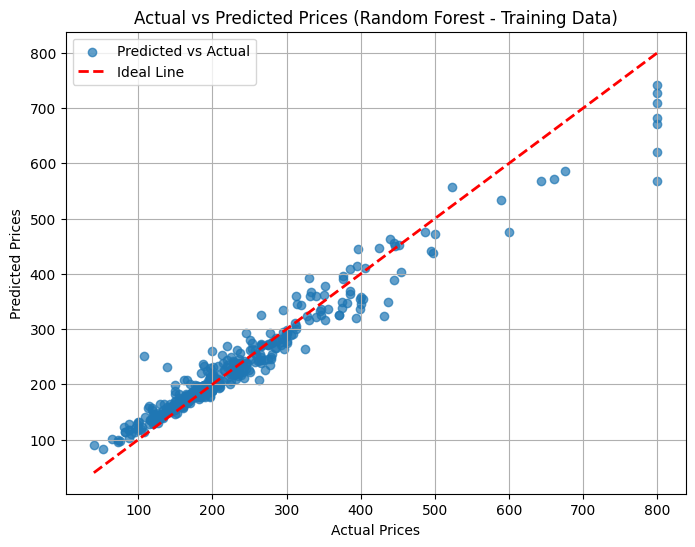

In [ ]:
# Make predictions on the training set
y_train_pred_rf = rf.predict(X_train)

# Plot actual vs predicted prices for the Random Forest model on training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred_rf, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', linewidth=2, label="Ideal Line")
plt.title("Actual vs Predicted Prices (Random Forest - Training Data)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()


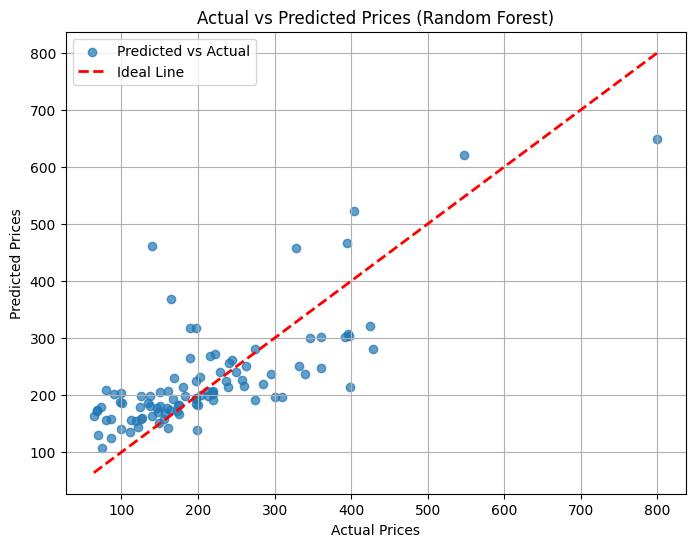

In [ ]:
# Assuming the Random Forest Regressor object 'rf' is already trained, calculate predictions and plot

# Make predictions on the test set
y_test_pred_rf = rf.predict(X_test)

# Plot actual vs predicted prices for the Random Forest model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label="Ideal Line")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


In [ ]:
# Calculate cumulative percentage of feature importances
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()

# Select top 90% features
top_90_percent_features = importance_df[importance_df['Cumulative Importance'] <= 0.90]


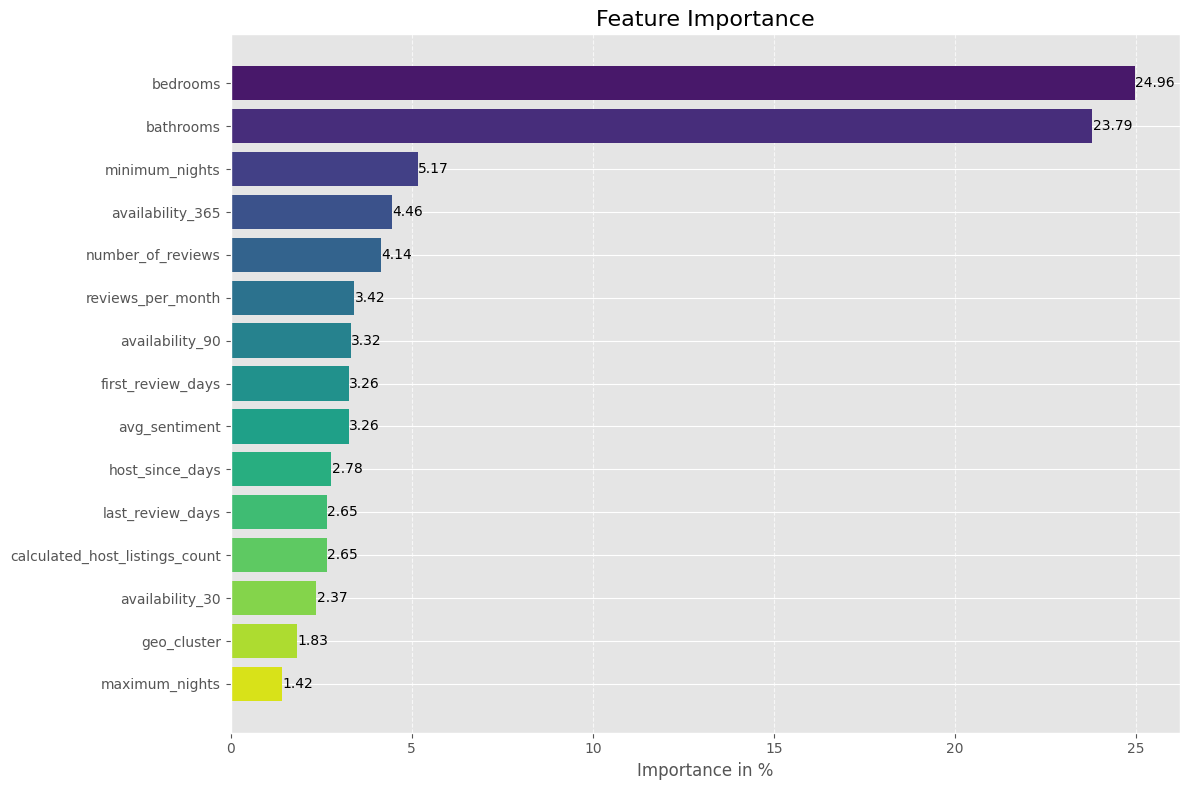

In [ ]:
# Enhanced Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('ggplot')

# Create the figure
plt.figure(figsize=(12, 8))

# Plot the horizontal bar chart
bars = plt.barh(
    top_90_percent_features['Feature'],
    top_90_percent_features['Importance'] * 100,
    color=sns.color_palette("viridis", len(top_90_percent_features))
)

# Add labels on bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center'
    )

# Add titles and labels
plt.xlabel('Importance in %', fontsize=12)
plt.title('Feature Importance', fontsize=16)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Show grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


### Model 3 - XGBoost

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),  # L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)  # L2 regularization
}

# Define the objective function
def objective(space):
    xgbr = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=space['min_child_weight'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        random_state=42
    )

    # Use the existing training set to fit
    xgbr.fit(X_train, y_train)

    # Evaluate using the training data for hyperopt optimization
    pred_train = xgbr.predict(X_train)
    mse = mean_squared_error(y_train, pred_train)

    return {'loss': mse, 'status': STATUS_OK}

# Skip if Trials object already exists; otherwise, initialize it
try:
    trials
except NameError:
    trials = Trials()

# Perform hyperparameter optimization
best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=300,  # Adjust as needed if you already have run iterations
    trials=trials
)

print("Best hyperparameters found:", best_hyperparams)

# Train the final model with the best hyperparameters
final_xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best_hyperparams['n_estimators']),
    max_depth=int(best_hyperparams['max_depth']),
    learning_rate=best_hyperparams.get('learning_rate', 0.1),  # Get or default
    subsample=best_hyperparams.get('subsample', 0.8),  # Provide a default value for 'subsample'
    colsample_bytree=best_hyperparams.get('colsample_bytree', 0.8),  # Provide a default value for 'colsample_bytree'
    min_child_weight=best_hyperparams.get('min_child_weight', 5),  # Provide a default value for 'min_child_weight'
    reg_alpha=best_hyperparams.get('reg_alpha', 0.0),  # Get 'reg_alpha' or default to 0.0 if not found
    reg_lambda=best_hyperparams.get('reg_lambda', 0.0),  # Get 'reg_lambda' or default to 0.0 if not found
    random_state=42,
    enable_categorical=True # Add this line to enable categorical data handling
)

# Fit to the training data
final_xgbr.fit(X_train, y_train)

# Predict on the test dataset
y_test_pred = final_xgbr.predict(X_test)
# Calculate final metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred) # Call r2_score to calculate R-squared

100%|██████████| 300/300 [00:00<?, ?trial/s, best loss=?]
Best hyperparameters found: {'ccp_alpha': 0.3461557162280537, 'max_depth': 308.0, 'max_features': 0.6161660314360321, 'min_child_weight': 0.1065209019802239, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 269.0, 'warm_start': 1}


In [ ]:
best_hyperparams

{'ccp_alpha': 0.3461557162280537,
 'max_depth': 308.0,
 'max_features': 0.6161660314360321,
 'min_child_weight': 0.1065209019802239,
 'min_samples_leaf': 1.0,
 'min_samples_split': 2.0,
 'n_estimators': 269.0,
 'warm_start': 1}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = final_xgbr.predict(X_test) # Use the trained XGBoost model 'final_xgbr'

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

MSE: 6094.0453
RMSE: 78.0644
MAE: 55.6965
R-squared: 0.5453


<ipython-input-70-55dbb22024f8>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')


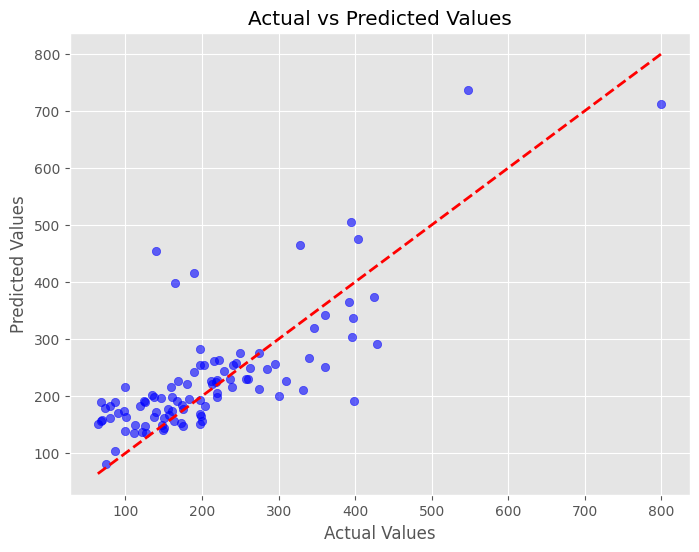

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


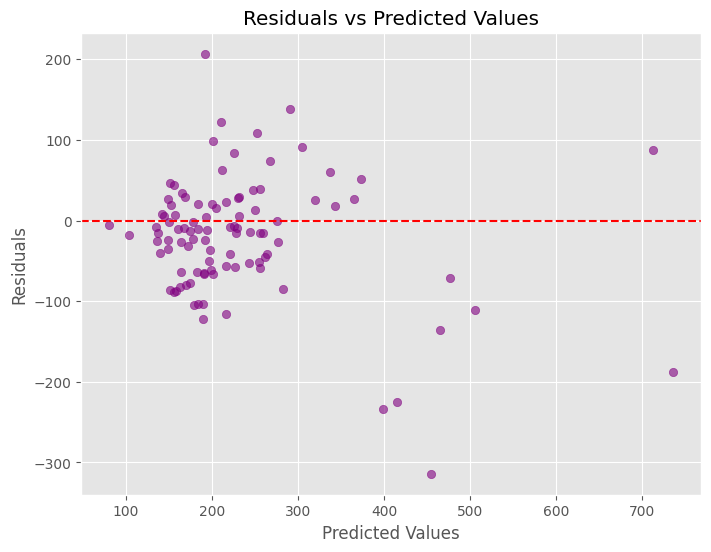

In [ ]:
# Calculate residuals
residuals = y_test - y_test_pred

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


                           Feature   Importance  Percentage
5                        bathrooms  5972.320067   93.468025
20                        property   732.428546   11.462656
9                  availability_30   265.028082    4.147743
24                        elevator   166.579934    2.607010
40                   avg_sentiment   138.975723    2.174998
14  calculated_host_listings_count    74.385725    1.164152
15               reviews_per_month    74.010078    1.158273
27                         hot_tub    49.294547    0.771470
39                       furniture    11.310958    0.177019
32                        backyard    10.590025    0.165736
38                         luggage     4.786882    0.074916
4                        room_type     2.168516    0.033938
19                last_review_days     0.485875    0.007604
33                  outdoor_dining     0.363037    0.005682
11                availability_365     0.017393    0.000272


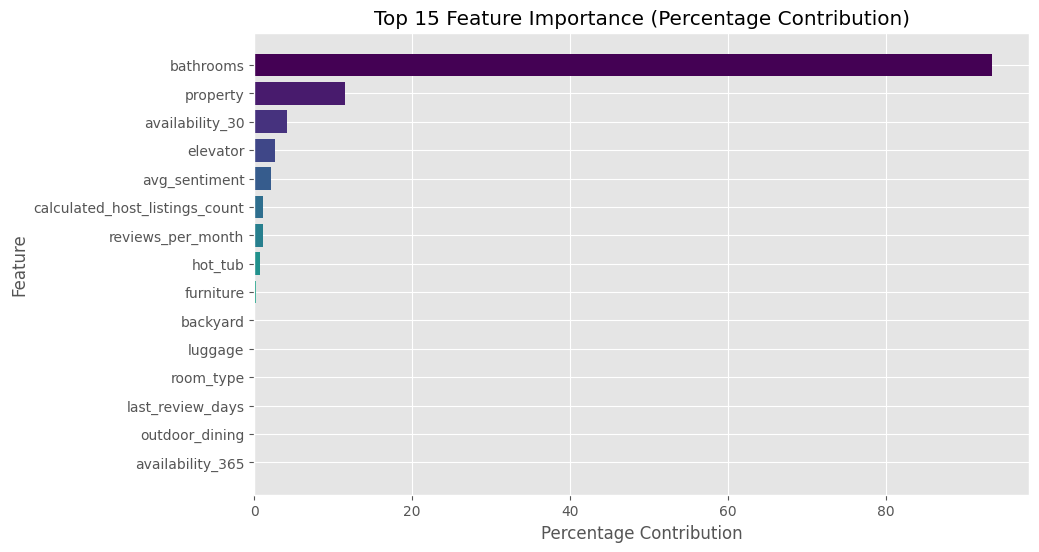

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Assuming your XGBoost model is named 'xg_model' and data is already prepared
# Replace 'xg_model' with 'final_xgbr' (your trained XGBoost model)
# Scale X_test before using it in permutation_importance
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)  # Scale X_test using StandardScaler

result = permutation_importance(
    final_xgbr, X_test_scaled, y_test,  # Use final_xgbr instead of xg_model
    scoring='neg_mean_squared_error', n_repeats=5, random_state=42
)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Calculate percentage contribution
importance_df['Percentage'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Select the top 15 features
top_features = importance_df.head(15)

# Display the DataFrame
print(top_features)

# Generate a colormap for the top features
colormap = plt.cm.viridis  # You can change this to any colormap you prefer
colors = colormap(np.linspace(0, 1, len(top_features)))

# Plot feature importance for the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Percentage'], color=colors)
plt.xlabel('Percentage Contribution')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Percentage Contribution)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [ ]:
import pandas as pd

# Get feature importance
# Replace 'xg_model' with 'final_xgbr' to use the correct model object
importance = final_xgbr.get_booster().get_score(importance_type='weight')

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))

               Feature  Importance
0   host_response_time      3285.0
2    host_is_superhost      3042.0
5            bathrooms      2941.0
9      availability_30      2819.0
6             bedrooms      2655.0
7       minimum_nights      2400.0
8       maximum_nights      2350.0
1   host_response_rate      2325.0
11    availability_365      1909.0
12   number_of_reviews      1668.0


### Model 4 - Neural Network

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Load Data (Assuming `model_input_df` is already prepared)
X = model_input_df.drop(columns=['price'])
y = model_input_df['price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Neural Network with Regularization and Dropout
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# Compile the Model with Advanced Optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Display Model Summary
nn_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,777 (171.00 KB)

 Trainable params: 43,777 (171.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 65315.0352 - mae: 222.3640 - val_loss: 22708.8320 - val_mae: 120.5710
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18288.4473 - mae: 95.6058 - val_loss: 14362.5645 - val_mae: 94.4201
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12854.5811 - mae: 80.7094 - val_loss: 8778.7383 - val_mae: 69.7279
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8858.6396 - mae: 69.3690 - val_loss: 5835.7637 - val_mae: 56.2343
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7086.5225 - mae: 59.9693 - val_loss: 5570.9873 - val_mae: 57.3566
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4190.4839 - mae: 47.2721 - val_loss: 5585.8804 - val_mae: 58.3017
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4950.1313 - mae: 48.7268 - val_loss: 5136.3511 - val_mae: 54.9537
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5188.9287 - mae: 48.6699 - val_loss: 5551.3613 - val_mae: 

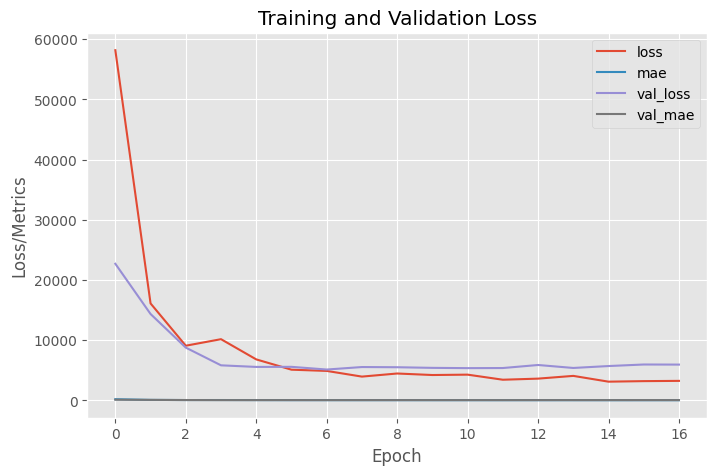

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6424.6411 - mae: 61.8799 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
# Train the Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = nn_model.fit(
    X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping]
)

# Plot Training History
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss/Metrics')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the Model
test_loss, test_mae = nn_model.evaluate(X_test_scaled, y_test)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

In [ ]:
# Metrics
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"R² Score: {r2_score(y_test, y_pred_nn)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_nn)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn)}")

Test Loss: 5547.85595703125
Test MAE: 58.66376876831055
R² Score: 0.5866392767943736
MSE: 5540.34969652315
MAE: 58.663769624671154


<ipython-input-65-94e6ca955f41>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


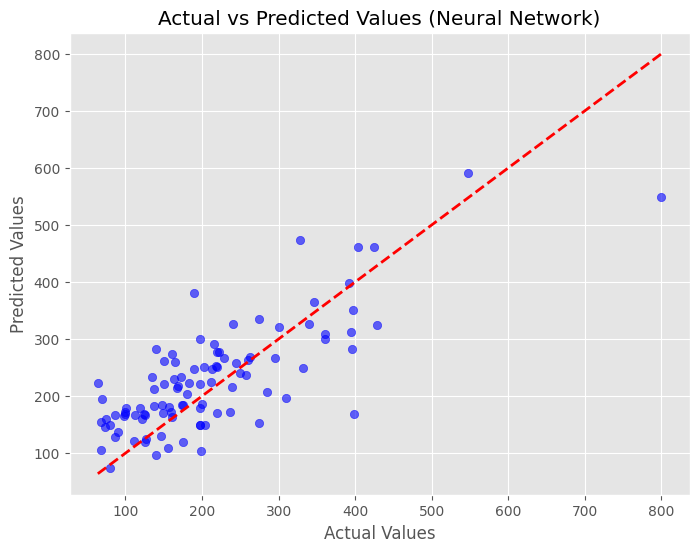

In [ ]:

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Neural Network)')
plt.show()

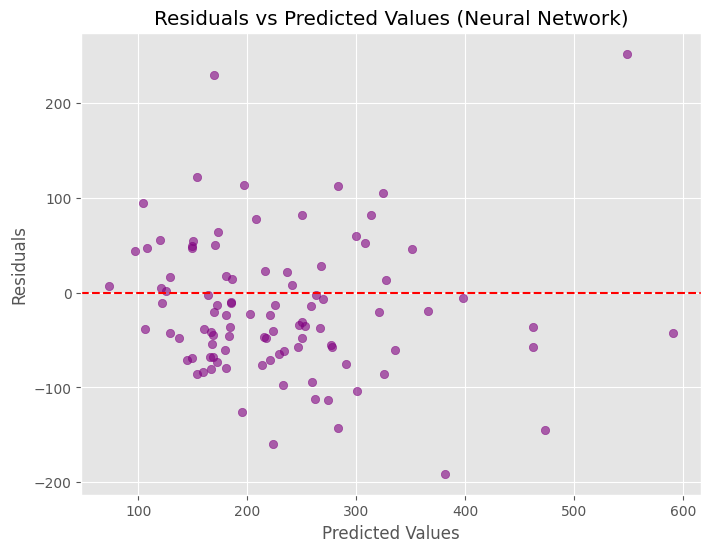

In [ ]:
# Residual Plot
residuals_nn = y_test - y_pred_nn
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_nn, residuals_nn, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Neural Network)')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━

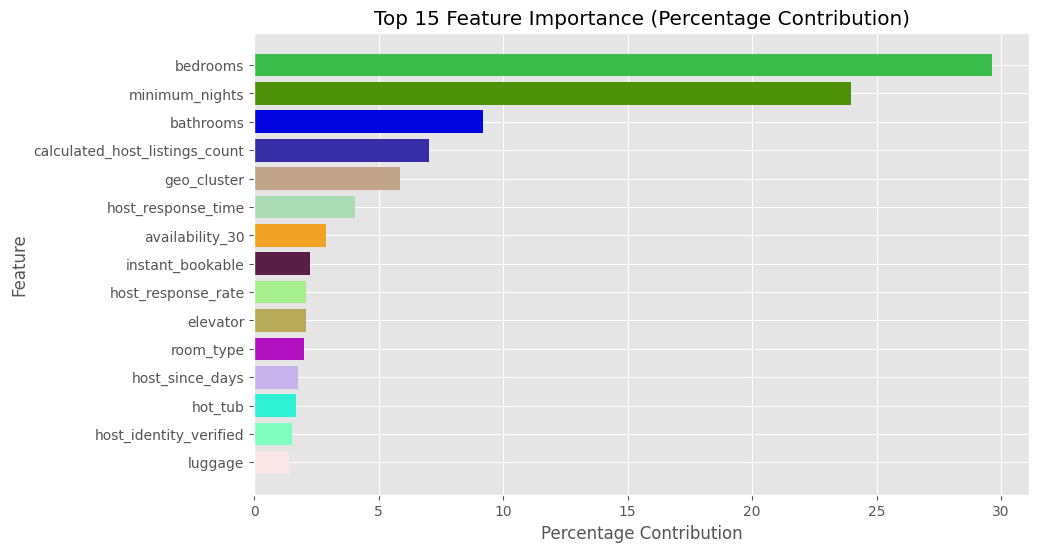

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute permutation importance on the full test dataset
result = permutation_importance(
    nn_model, X_test_scaled, y_test,
    scoring='neg_mean_squared_error', n_repeats=5, random_state=42
)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Calculate percentage contribution
importance_df['Percentage'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Select the top 15 features
top_features = importance_df.head(15)

# Display the DataFrame
print(top_features)

# Generate random colors for the top 15 features
colors = np.random.rand(len(top_features), 3)

# Plot feature importance for the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Percentage'], color=colors)
plt.xlabel('Percentage Contribution')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Percentage Contribution)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
